In [1]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import glob
import os

import tensorly as tl
from tensorly.decomposition import parafac, partial_tucker

#from __future__ import division

from scipy.sparse.linalg import svds
from scipy.optimize import minimize_scalar


from torch.autograd import Variable

import sys
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import argparse
from operator import itemgetter
import time

from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# VBMF

In [2]:
torch.cuda.is_available()
torch.cuda.get_device_name(device=None)

# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=1)

# Utilities

In [4]:
def VBMF(Y, cacb, sigma2=None, H=None):
    """Implementation of the analytical solution to Variational Bayes Matrix Factorization.

    This function can be used to calculate the analytical solution to VBMF. 
    This is based on the paper and MatLab code by Nakajima et al.:
    "Global analytic solution of fully-observed variational Bayesian matrix factorization."

    Notes
    -----
        If sigma2 is unspecified, it is estimated by minimizing the free energy.
        If H is unspecified, it is set to the smallest of the sides of the input Y.
        To estimate cacb, use the function EVBMF().

    Attributes
    ----------
    Y : numpy-array
        Input matrix that is to be factorized. Y has shape (L,M), where L<=M.
        
    cacb : int
        Product of the prior variances of the matrices that factorize the input.
    
    sigma2 : int or None (default=None)
        Variance of the noise on Y.
        
    H : int or None (default = None)
        Maximum rank of the factorized matrices.
        
    Returns
    -------
    U : numpy-array
        Left-singular vectors. 
        
    S : numpy-array
        Diagonal matrix of singular values.
        
    V : numpy-array
        Right-singular vectors.
        
    post : dictionary
        Dictionary containing the computed posterior values.
        
        
    References
    ----------
    .. [1] Nakajima, Shinichi, et al. "Global analytic solution of fully-observed variational Bayesian matrix factorization." Journal of Machine Learning Research 14.Jan (2013): 1-37.
    
    .. [2] Nakajima, Shinichi, et al. "Perfect dimensionality recovery by variational Bayesian PCA." Advances in Neural Information Processing Systems. 2012.
    """    
    
    L,M = Y.shape #has to be L<=M

    if H is None:
        H = L
    
    #SVD of the input matrix, max rank of H
    U,s,V = np.linalg.svd(Y)
    U = U[:,:H]
    s = s[:H]
    V = V[:H].T 

    #Calculate residual
    residual = 0.
    if H<L:
        residual = np.sum(np.sum(Y**2)-np.sum(s**2))

    #Estimation of the variance when sigma2 is unspecified
    if sigma2 is None: 
        upper_bound = (np.sum(s**2)+ residual)/(L+M)

        if L==H: 
            lower_bound = s[-1]**2/M
        else:
            lower_bound = residual/((L-H)*M)

        sigma2_opt = minimize_scalar(VBsigma2, args=(L,M,cacb,s,residual), bounds=[lower_bound, upper_bound], method='Bounded')
        sigma2 = sigma2_opt.x
        print("Estimated sigma2: ", sigma2)

    #Threshold gamma term
    #Formula above (21) from [1]
    thresh_term = (L+M + sigma2/cacb**2)/2 
    threshold = np.sqrt( sigma2 * (thresh_term + np.sqrt(thresh_term**2 - L*M) ))
              
    #Number of singular values where gamma>threshold
    pos = np.sum(s>threshold)

    #Formula (10) from [2]
    d = np.multiply(s[:pos], 
                    1 - np.multiply(sigma2/(2*s[:pos]**2),
                                    L+M+np.sqrt( (M-L)**2 + 4*s[:pos]**2/cacb**2 )))

    #Computation of the posterior
    post = {}
    zeta = sigma2/(2*L*M) * (L+M+sigma2/cacb**2 - np.sqrt((L+M+sigma2/cacb**2)**2 - 4*L*M))
    post['ma'] = np.zeros(H) 
    post['mb'] = np.zeros(H)
    post['sa2'] = cacb * (1-L*zeta/sigma2) * np.ones(H)
    post['sb2'] = cacb * (1-M*zeta/sigma2) * np.ones(H)  

    delta = cacb/sigma2 * (s[:pos]-d- L*sigma2/s[:pos])
    post['ma'][:pos] = np.sqrt(np.multiply(d, delta))
    post['mb'][:pos] = np.sqrt(np.divide(d, delta))
    post['sa2'][:pos] = np.divide(sigma2*delta, s[:pos])
    post['sb2'][:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))
    post['sigma2'] = sigma2
    post['F'] = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 - (L+M)*H
               + np.sum(M*np.log(cacb/post['sa2']) + L*np.log(cacb/post['sb2'])
                        + (post['ma']**2 + M*post['sa2'])/cacb + (post['mb']**2 + L*post['sb2'])/cacb
                        + (-2 * np.multiply(np.multiply(post['ma'], post['mb']), s)
                           + np.multiply(post['ma']**2 + M*post['sa2'],post['mb']**2 + L*post['sb2']))/sigma2))

    return U[:,:pos], np.diag(d), V[:,:pos], post


def VBsigma2(sigma2,L,M,cacb,s,residual):
    H = len(s)

    thresh_term = (L+M + sigma2/cacb**2)/2 
    threshold = np.sqrt( sigma2 * (thresh_term + np.sqrt(thresh_term**2 - L*M) ))
    pos = np.sum(s>threshold)
    
    d = np.multiply(s[:pos], 
                    1 - np.multiply(sigma2/(2*s[:pos]**2),
                                    L+M+np.sqrt( (M-L)**2 + 4*s[:pos]**2/cacb**2 )))

    zeta = sigma2/(2*L*M) * (L+M+sigma2/cacb**2 - np.sqrt((L+M+sigma2/cacb**2)**2 - 4*L*M))
    post_ma = np.zeros(H) 
    post_mb = np.zeros(H)
    post_sa2 = cacb * (1-L*zeta/sigma2) * np.ones(H)
    post_sb2 = cacb * (1-M*zeta/sigma2) * np.ones(H)  

    delta = cacb/sigma2 * (s[:pos]-d- L*sigma2/s[:pos])
    post_ma[:pos] = np.sqrt(np.multiply(d, delta))
    post_mb[:pos] = np.sqrt(np.divide(d, delta))
    post_sa2[:pos] = np.divide(sigma2*delta, s[:pos])
    post_sb2[:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))

    F = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 - (L+M)*H
               + np.sum(M*np.log(cacb/post_sa2) + L*np.log(cacb/post_sb2)
                        + (post_ma**2 + M*post_sa2)/cacb + (post_mb**2 + L*post_sb2)/cacb
                        + (-2 * np.multiply(np.multiply(post_ma, post_mb), s)
                           + np.multiply(post_ma**2 + M*post_sa2,post_mb**2 + L*post_sb2))/sigma2))
    return F



def EVBMF(Y, sigma2=None, H=None):
    """Implementation of the analytical solution to Empirical Variational Bayes Matrix Factorization.

    This function can be used to calculate the analytical solution to empirical VBMF. 
    This is based on the paper and MatLab code by Nakajima et al.:
    "Global analytic solution of fully-observed variational Bayesian matrix factorization."

    Notes
    -----
        If sigma2 is unspecified, it is estimated by minimizing the free energy.
        If H is unspecified, it is set to the smallest of the sides of the input Y.

    Attributes
    ----------
    Y : numpy-array
        Input matrix that is to be factorized. Y has shape (L,M), where L<=M.
    
    sigma2 : int or None (default=None)
        Variance of the noise on Y.
        
    H : int or None (default = None)
        Maximum rank of the factorized matrices.
        
    Returns
    -------
    U : numpy-array
        Left-singular vectors. 
        
    S : numpy-array
        Diagonal matrix of singular values.
        
    V : numpy-array
        Right-singular vectors.
        
    post : dictionary
        Dictionary containing the computed posterior values.
        
        
    References
    ----------
    .. [1] Nakajima, Shinichi, et al. "Global analytic solution of fully-observed variational Bayesian matrix factorization." Journal of Machine Learning Research 14.Jan (2013): 1-37.
    
    .. [2] Nakajima, Shinichi, et al. "Perfect dimensionality recovery by variational Bayesian PCA." Advances in Neural Information Processing Systems. 2012.     
    """   
    L,M = Y.shape #has to be L<=M

    if H is None:
        H = L

    alpha = L/M
    tauubar = 2.5129*np.sqrt(alpha)
    
    #SVD of the input matrix, max rank of H
    U,s,V = np.linalg.svd(Y)
    U = U[:,:H]
    s = s[:H]
    V = V[:H].T 

    #Calculate residual
    residual = 0.
    if H<L:
        residual = np.sum(np.sum(Y**2)-np.sum(s**2))

    #Estimation of the variance when sigma2 is unspecified
    if sigma2 is None: 
        xubar = (1+tauubar)*(1+alpha/tauubar)
        eH_ub = int(np.min([np.ceil(L/(1+alpha))-1, H]))-1
        upper_bound = (np.sum(s**2)+residual)/(L*M)
        lower_bound = np.max([s[eH_ub+1]**2/(M*xubar), np.mean(s[eH_ub+1:]**2)/M])

        scale = 1.#/lower_bound
        s = s*np.sqrt(scale)
        residual = residual*scale
        lower_bound = lower_bound*scale
        upper_bound = upper_bound*scale

        sigma2_opt = minimize_scalar(EVBsigma2, args=(L,M,s,residual,xubar), bounds=[lower_bound, upper_bound], method='Bounded')
        sigma2 = sigma2_opt.x

    #Threshold gamma term
    threshold = np.sqrt(M*sigma2*(1+tauubar)*(1+alpha/tauubar))
    pos = np.sum(s>threshold)

    #Formula (15) from [2]
    d = np.multiply(s[:pos]/2, 1-np.divide((L+M)*sigma2, s[:pos]**2) + np.sqrt((1-np.divide((L+M)*sigma2, s[:pos]**2))**2 -4*L*M*sigma2**2/s[:pos]**4) )

    #Computation of the posterior
    post = {}
    post['ma'] = np.zeros(H) 
    post['mb'] = np.zeros(H)
    post['sa2'] = np.zeros(H) 
    post['sb2'] = np.zeros(H) 
    post['cacb'] = np.zeros(H)  

    tau = np.multiply(d, s[:pos])/(M*sigma2)
    delta = np.multiply(np.sqrt(np.divide(M*d, L*s[:pos])), 1+alpha/tau)

    post['ma'][:pos] = np.sqrt(np.multiply(d, delta))
    post['mb'][:pos] = np.sqrt(np.divide(d, delta))
    post['sa2'][:pos] = np.divide(sigma2*delta, s[:pos])
    post['sb2'][:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))
    post['cacb'][:pos] = np.sqrt(np.multiply(d, s[:pos])/(L*M))
    post['sigma2'] = sigma2
    post['F'] = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 
                     + np.sum(M*np.log(tau+1) + L*np.log(tau/alpha +1) - M*tau))

    return U[:,:pos], np.diag(d), V[:,:pos], post

def EVBsigma2(sigma2,L,M,s,residual,xubar):
    H = len(s)

    alpha = L/M
    x = s**2/(M*sigma2) 

    z1 = x[x>xubar]
    z2 = x[x<=xubar]
    tau_z1 = tau(z1, alpha)

    term1 = np.sum(z2 - np.log(z2))
    term2 = np.sum(z1 - tau_z1)
    term3 = np.sum( np.log( np.divide(tau_z1+1, z1)))
    term4 = alpha*np.sum(np.log(tau_z1/alpha+1))
    
    obj = term1+term2+term3+term4+ residual/(M*sigma2) + (L-H)*np.log(sigma2)

    return obj

def phi0(x):
    return x-np.log(x)

def phi1(x, alpha):
    return np.log(tau(x,alpha)+1) + alpha*np.log(tau(x,alpha)/alpha + 1) - tau(x,alpha)

def tau(x, alpha):
    return 0.5 * (x-(1+alpha) + np.sqrt((x-(1+alpha))**2 - 4*alpha))

# Data sets

In [5]:
def loader(path, batch_size=5, num_workers=4, pin_memory=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return data.DataLoader(
        datasets.ImageFolder(path,
                             transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize,
                             ])),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory)

def test_loader(path, batch_size=5, num_workers=4, pin_memory=True): 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return data.DataLoader(
        datasets.ImageFolder(path,
                             transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 normalize,
                             ])),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory)

# Decompositions

In [6]:

def cp_decomposition_conv_layer(layer, rank):
    """ Gets a conv layer and a target rank, 
        returns a nn.Sequential object with the decomposition """

    # Perform CP decomposition on the layer weight tensorly. 
    last, first, vertical, horizontal = \
        parafac(layer.weight.data, rank=rank, init='svd')

    pointwise_s_to_r_layer = torch.nn.Conv2d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1, stride=1, padding=0, 
            dilation=layer.dilation, bias=False)

    depthwise_vertical_layer = torch.nn.Conv2d(in_channels=vertical.shape[1], 
            out_channels=vertical.shape[1], kernel_size=(vertical.shape[0], 1),
            stride=1, padding=(layer.padding[0], 0), dilation=layer.dilation,
            groups=vertical.shape[1], bias=False)

    depthwise_horizontal_layer = \
        torch.nn.Conv2d(in_channels=horizontal.shape[1], \
            out_channels=horizontal.shape[1], 
            kernel_size=(1, horizontal.shape[0]), stride=layer.stride,
            padding=(0, layer.padding[0]), 
            dilation=layer.dilation, groups=horizontal.shape[1], bias=False)

    pointwise_r_to_t_layer = torch.nn.Conv2d(in_channels=last.shape[1], \
            out_channels=last.shape[0], kernel_size=1, stride=1,
            padding=0, dilation=layer.dilation, bias=True)

    pointwise_r_to_t_layer.bias.data = layer.bias.data

    depthwise_horizontal_layer.weight.data = \
        torch.transpose(horizontal, 1, 0).unsqueeze(1).unsqueeze(1)
    depthwise_vertical_layer.weight.data = \
        torch.transpose(vertical, 1, 0).unsqueeze(1).unsqueeze(-1)
    pointwise_s_to_r_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    pointwise_r_to_t_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)

    new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer, \
                    depthwise_horizontal_layer, pointwise_r_to_t_layer]
    
    return nn.Sequential(*new_layers)

def estimate_ranks(layer):
    """ Unfold the 2 modes of the Tensor the decomposition will 
    be performed on, and estimates the ranks of the matrices using VBMF 
    """

    weights = layer.weight.data
    unfold_0 = tl.base.unfold(weights, 0) 
    unfold_1 = tl.base.unfold(weights, 1)
    # _, diag_0, _, _ = VBMF.EVBMF(unfold_0)
    # _, diag_1, _, _ = VBMF.EVBMF(unfold_1)
    _, diag_0, _, _ = EVBMF(unfold_0)
    _, diag_1, _, _ = EVBMF(unfold_1)
    
    ranks = [diag_0.shape[0], diag_1.shape[1]]
    return ranks

def tucker_decomposition_conv_layer(layer):
    """ Gets a conv layer, 
        returns a nn.Sequential object with the Tucker decomposition.
        The ranks are estimated with a Python implementation of VBMF
        https://github.com/CasvandenBogaard/VBMF
    """

    ranks = estimate_ranks(layer)
    print(layer, "VBMF Estimated ranks", ranks)
    core, [last, first] = \
        partial_tucker(layer.weight.data, \
            modes=[0, 1], ranks=ranks, init='svd')

    # A pointwise convolution that reduces the channels from S to R3
    first_layer = torch.nn.Conv2d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1,
            stride=1, padding=0, dilation=layer.dilation, bias=False)

    # A regular 2D convolution layer with R3 input channels 
    # and R3 output channels
    core_layer = torch.nn.Conv2d(in_channels=core.shape[1], \
            out_channels=core.shape[0], kernel_size=layer.kernel_size,
            stride=layer.stride, padding=layer.padding, dilation=layer.dilation,
            bias=False)

    # A pointwise convolution that increases the channels from R4 to T
    last_layer = torch.nn.Conv2d(in_channels=last.shape[1], \
        out_channels=last.shape[0], kernel_size=1, stride=1,
        padding=0, dilation=layer.dilation, bias=True)

    last_layer.bias.data = layer.bias.data

    first_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    last_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)
    core_layer.weight.data = core

    new_layers = [first_layer, core_layer, last_layer]
    return nn.Sequential(*new_layers)

# Train

In [11]:
# VGG16 based network for classifying between dogs and cats.
# After training this will be an over parameterized network,
# with potential to shrink it.
class ModifiedVGG19Model(torch.nn.Module):
    def __init__(self, model=None):
        super(ModifiedVGG19Model, self).__init__()

        model = models.vgg19(pretrained=True)
        # print("preload model is", model.classifier[6].weight.shape)
        self.features = model.features
        
        '''
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2))
        '''
        self.classifier = model.classifier
        # self.classifier = nn.Linear(25088, 2)
        # self.classifier.weights = torch.load('ant_bee_VGG19_FC_25088_2_acc9542_bias.pt')
        # self.classifier.weights = torch.load('ant_bee_VGG19_FC_25088_2_acc9542_bias.pt')
        
        # for param in self.features.parameters():
        #     param.requires_grad = False
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Trainer:
    def __init__(self, train_path, test_path, model, optimizer):
        self.train_data_loader = loader(train_path)
        self.test_data_loader = test_loader(test_path)

        self.optimizer = optimizer

        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model.train()

    def test(self):
        self.model.cuda(device)
        self.model.eval()
        correct = 0
        total = 0
        total_time = 0
        for i, (batch, label) in enumerate(self.test_data_loader):
            batch = batch.cuda(device)
            t0 = time.time()
            output = model(Variable(batch)).cpu()
            t1 = time.time()
            total_time = total_time + (t1 - t0)
            pred = output.data.max(1)[1]
            correct += pred.cpu().eq(label).sum()
            
            total += label.size(0)
        
        
        print("Accuracy :", float(correct) / total)
        print("Average prediction time", float(total_time) / (i + 1), i + 1)

        self.model.train()
        return float(correct) / total

    # Very ugly setting!!!
    # this train function is not the actual train, it's just some setting
    # train -> train_epoch -> train_batch all are just setting environment
    # Then the self.test is the actual training step
    def train(self, epoches=10):
        
        acc_history = []
        
        for i in range(epoches):
            print("Epoch: ", i)
            self.train_epoch()
            accuracy = self.test()
            acc_history.append(accuracy)
            
            if i % 50 == 0:
                plt.plot(acc_history)
                plt.show()
                
        print("Finished fine tuning.")
        

    def train_batch(self, batch, label):
        self.model.zero_grad()
        input = Variable(batch)
        self.criterion(self.model(input), Variable(label)).backward()
        self.optimizer.step()

    def train_epoch(self):
        for i, (batch, label) in enumerate(self.train_data_loader):
            #print('batch is:', batch.shape)
            #print('label is:', label.shape)
            self.train_batch(batch.cuda(device), label.cuda(device))
            

'''
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--train", dest="train", action="store_true")
    parser.add_argument("--decompose", dest="decompose", action="store_true")
    parser.add_argument("--fine_tune", dest="fine_tune", action="store_true")
    parser.add_argument("--train_path", type = str, default = "train")
    parser.add_argument("--test_path", type = str, default = "test")
    parser.add_argument("--cp", dest="cp", action="store_true", \
        help="Use cp decomposition. uses tucker by default")
    parser.set_defaults(train=False)
    parser.set_defaults(decompose=False)
    parser.set_defaults(fine_tune=False)
    parser.set_defaults(cp=False)    
    args = parser.parse_args()
    return args
'''

'\ndef get_args():\n    parser = argparse.ArgumentParser()\n    parser.add_argument("--train", dest="train", action="store_true")\n    parser.add_argument("--decompose", dest="decompose", action="store_true")\n    parser.add_argument("--fine_tune", dest="fine_tune", action="store_true")\n    parser.add_argument("--train_path", type = str, default = "train")\n    parser.add_argument("--test_path", type = str, default = "test")\n    parser.add_argument("--cp", dest="cp", action="store_true",         help="Use cp decomposition. uses tucker by default")\n    parser.set_defaults(train=False)\n    parser.set_defaults(decompose=False)\n    parser.set_defaults(fine_tune=False)\n    parser.set_defaults(cp=False)    \n    args = parser.parse_args()\n    return args\n'

Lets take a look at the changed model: ModifiedVGG19Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Co

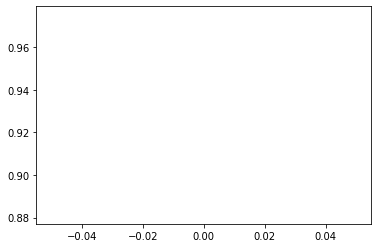

Epoch:  1
Accuracy : 0.9607843137254902
Average prediction time 0.04065480539875646 31
Epoch:  2
Accuracy : 0.9281045751633987
Average prediction time 0.04077927527889129 31
Epoch:  3
Accuracy : 0.9281045751633987
Average prediction time 0.039836337489466515 31
Epoch:  4
Accuracy : 0.9477124183006536
Average prediction time 0.04028938662621283 31
Epoch:  5
Accuracy : 0.9281045751633987
Average prediction time 0.04137318365035519 31
Epoch:  6
Accuracy : 0.9477124183006536
Average prediction time 0.0409566048652895 31
Epoch:  7
Accuracy : 0.9477124183006536
Average prediction time 0.04075469509247811 31
Epoch:  8
Accuracy : 0.9607843137254902
Average prediction time 0.04221876205936555 31
Epoch:  9
Accuracy : 0.9477124183006536
Average prediction time 0.042055891406151555 31
Epoch:  10
Accuracy : 0.954248366013072
Average prediction time 0.04099559014843356 31
Epoch:  11
Accuracy : 0.9477124183006536
Average prediction time 0.04201622163095782 31
Epoch:  12
Accuracy : 0.954248366013072
A

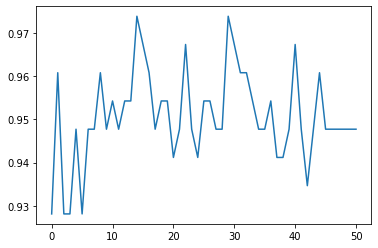

Epoch:  51
Accuracy : 0.9477124183006536
Average prediction time 0.041648634018436555 31
Epoch:  52
Accuracy : 0.9673202614379085
Average prediction time 0.041515673360516946 31
Epoch:  53
Accuracy : 0.954248366013072
Average prediction time 0.04192247698383947 31
Epoch:  54
Accuracy : 0.954248366013072
Average prediction time 0.042239519857591196 31
Epoch:  55
Accuracy : 0.954248366013072
Average prediction time 0.04134971095669654 31
Epoch:  56
Accuracy : 0.954248366013072
Average prediction time 0.04228622682632938 31
Epoch:  57
Accuracy : 0.9477124183006536
Average prediction time 0.041717536987796906 31
Epoch:  58
Accuracy : 0.9477124183006536
Average prediction time 0.0422677916865195 31
Epoch:  59
Accuracy : 0.954248366013072
Average prediction time 0.04214795174137238 31
Epoch:  60
Accuracy : 0.9607843137254902
Average prediction time 0.04176762796217395 31
Epoch:  61
Accuracy : 0.9607843137254902
Average prediction time 0.0417424863384616 31
Epoch:  62
Accuracy : 0.96078431372

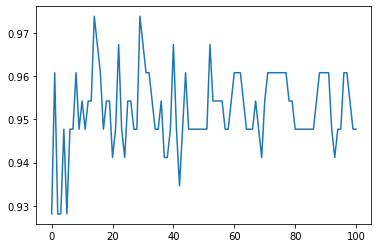

Epoch:  101
Accuracy : 0.9477124183006536
Average prediction time 0.04132428476887365 31
Epoch:  102
Accuracy : 0.9477124183006536
Average prediction time 0.04162860685779202 31
Epoch:  103
Accuracy : 0.9607843137254902
Average prediction time 0.04229737866309381 31
Epoch:  104
Accuracy : 0.9607843137254902
Average prediction time 0.04484421976151005 31
Epoch:  105
Accuracy : 0.9411764705882353
Average prediction time 0.042848202490037485 31
Epoch:  106
Accuracy : 0.9411764705882353
Average prediction time 0.04367069275148453 31
Epoch:  107
Accuracy : 0.954248366013072
Average prediction time 0.041909579307802265 31
Epoch:  108
Accuracy : 0.9477124183006536
Average prediction time 0.04123154763252505 31
Epoch:  109
Accuracy : 0.954248366013072
Average prediction time 0.04152797883556735 31
Epoch:  110
Accuracy : 0.954248366013072
Average prediction time 0.044946024494786414 31
Epoch:  111
Accuracy : 0.954248366013072
Average prediction time 0.04357394864482264 31
Epoch:  112
Accuracy :

In [12]:
# args = get_args()
tl.set_backend('pytorch')

#if args.train:
# ---------------------Train -----------------------------------
model = ModifiedVGG19Model().cuda(device)
print("Lets take a look at the changed model:", model)

print("Model grads:")
for name,param in model.named_parameters():
    print("\t",name, param.requires_grad)
    
optimizer = optim.SGD(model.classifier.parameters(), lr=0.0001, momentum=0.99)
# trainer = Trainer('data/cats_and_dogs/train', 'data/cats_and_dogs/test1', model, optimizer)

trainer = Trainer('data/hymenoptera_data/train', 'data/hymenoptera_data/val', model, optimizer)

trainer.train(epoches = 125)
torch.save(model, "Model_VGG19_Scratch_Ant_Bee_acc9412")


In [ ]:
# below, need to change library functions:
# ~/.conda/envs/prune/lib/python3.7/site-packages/tensorly/backend/pytorch_backend.py in solve(self, matrix1, matrix2)
#     110             solution, _ = torch.gels(matrix2, matrix1)
#     111         else:
# --> 112             solution, _ = torch.gesv(matrix2, matrix1)
#     113         return solution
#     114 

# AttributeError: module 'torch' has no attribute 'gesv'

In [13]:
#elif args.decompose:
# -----------------Decompose ----------------------

model = torch.load("Model_VGG19_Scratch_Ant_Bee_acc9412").cuda(device)
model.eval()
model.cpu()
N = len(model.features._modules.keys())
cp = False

for i, key in enumerate(model.features._modules.keys()):

    if i >= N - 2:
        break
    if isinstance(model.features._modules[key], torch.nn.modules.conv.Conv2d):
        conv_layer = model.features._modules[key]
        # if args.cp:
        if cp:
            rank = max(conv_layer.weight.data.numpy().shape)//3
            decomposed = cp_decomposition_conv_layer(conv_layer, rank)
        else:
            decomposed = tucker_decomposition_conv_layer(conv_layer)

        model.features._modules[key] = decomposed

    torch.save(model, 'decomposed_model')

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [14, 2]
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [26, 31]
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [38, 33]
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [40, 42]
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [71, 58]
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [79, 82]
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [77, 78]
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [72, 75]
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [134, 111]
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [140, 150]
Conv2d(512, 512, kernel

In [14]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

DataParallel(
  (module): ModifiedVGG19Model(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(2, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(14, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ReLU(inplace=True)
      (2): Sequential(
        (0): Conv2d(64, 31, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(31, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(26, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Sequential(
        (0): Conv2d(64, 33, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(33, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(38, 128, kernel_size=(1, 1), stride=(1, 1))
      )
  

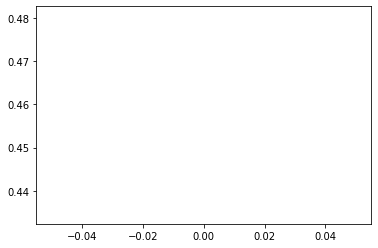

Epoch:  1
Accuracy : 0.7973856209150327
Average prediction time 0.20665051860194053 31
Epoch:  2
Accuracy : 0.6470588235294118
Average prediction time 0.20458625978039158 31
Epoch:  3
Accuracy : 0.5947712418300654
Average prediction time 0.20462741390351327 31
Epoch:  4
Accuracy : 0.7516339869281046
Average prediction time 0.20356915074010049 31
Epoch:  5
Accuracy : 0.7058823529411765
Average prediction time 0.20377989738218247 31
Epoch:  6
Accuracy : 0.7908496732026143
Average prediction time 0.2035807640321793 31
Epoch:  7
Accuracy : 0.7581699346405228
Average prediction time 0.20464148829060216 31
Epoch:  8
Accuracy : 0.45098039215686275
Average prediction time 0.20504127779314596 31
Epoch:  9
Accuracy : 0.738562091503268
Average prediction time 0.2041893236098751 31
Epoch:  10
Accuracy : 0.6535947712418301
Average prediction time 0.20362518679711125 31
Epoch:  11
Accuracy : 0.8104575163398693
Average prediction time 0.2037568553801506 31
Epoch:  12
Accuracy : 0.7777777777777778
Ave

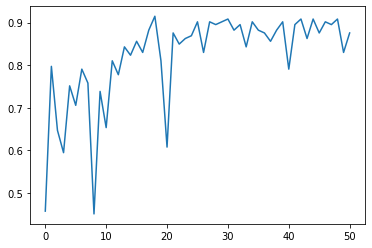

Epoch:  51
Accuracy : 0.8431372549019608
Average prediction time 0.20318740414034936 31
Epoch:  52
Accuracy : 0.8627450980392157
Average prediction time 0.20329859948927356 31
Epoch:  53
Accuracy : 0.5294117647058824
Average prediction time 0.20321970601235667 31
Epoch:  54
Accuracy : 0.9019607843137255
Average prediction time 0.20323832573429232 31
Epoch:  55
Accuracy : 0.9150326797385621
Average prediction time 0.2039454214034542 31
Epoch:  56
Accuracy : 0.9215686274509803
Average prediction time 0.20445915191404282 31
Epoch:  57
Accuracy : 0.9019607843137255
Average prediction time 0.2035722424907069 31
Epoch:  58
Accuracy : 0.8823529411764706
Average prediction time 0.20459827300040953 31
Epoch:  59
Accuracy : 0.8627450980392157
Average prediction time 0.20349042646346555 31
Epoch:  60
Accuracy : 0.9084967320261438
Average prediction time 0.20501105247005338 31
Epoch:  61
Accuracy : 0.9084967320261438
Average prediction time 0.2045267704994448 31
Epoch:  62
Accuracy : 0.84313725490

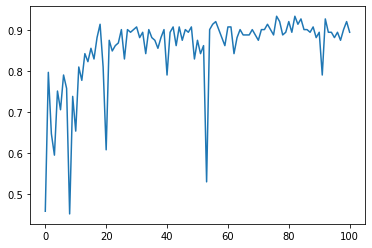

Epoch:  101
Accuracy : 0.9215686274509803
Average prediction time 0.20337853124064784 31
Epoch:  102
Accuracy : 0.9150326797385621
Average prediction time 0.20318605053809383 31
Epoch:  103
Accuracy : 0.8758169934640523
Average prediction time 0.2033063211748677 31
Epoch:  104
Accuracy : 0.8431372549019608
Average prediction time 0.20366930192516697 31
Epoch:  105
Accuracy : 0.8823529411764706
Average prediction time 0.2032069929184452 31
Epoch:  106
Accuracy : 0.9019607843137255
Average prediction time 0.2030977895182948 31
Epoch:  107
Accuracy : 0.9019607843137255
Average prediction time 0.20344623442619078 31
Epoch:  108
Accuracy : 0.869281045751634
Average prediction time 0.20327438077618998 31
Epoch:  109
Accuracy : 0.8823529411764706
Average prediction time 0.20306306500588694 31
Epoch:  110
Accuracy : 0.8627450980392157
Average prediction time 0.20320270138402138 31
Epoch:  111
Accuracy : 0.869281045751634
Average prediction time 0.20318371249783423 31
Epoch:  112
Accuracy : 0.9

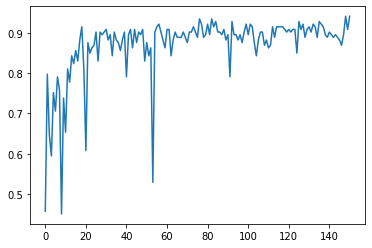

Epoch:  151
Accuracy : 0.9019607843137255
Average prediction time 0.20340811821722216 31
Epoch:  152
Accuracy : 0.9084967320261438
Average prediction time 0.203026948436614 31
Epoch:  153
Accuracy : 0.8888888888888888
Average prediction time 0.20326884331241732 31
Epoch:  154
Accuracy : 0.934640522875817
Average prediction time 0.20332824030230123 31
Epoch:  155
Accuracy : 0.9215686274509803
Average prediction time 0.20304710634293094 31
Epoch:  156
Accuracy : 0.9215686274509803
Average prediction time 0.20367067860018823 31
Epoch:  157
Accuracy : 0.9281045751633987
Average prediction time 0.20330379086156045 31
Epoch:  158
Accuracy : 0.9084967320261438
Average prediction time 0.2031364748554845 31
Epoch:  159
Accuracy : 0.9215686274509803
Average prediction time 0.20319760230279738 31
Epoch:  160
Accuracy : 0.9019607843137255
Average prediction time 0.2035092999858241 31
Epoch:  161
Accuracy : 0.9019607843137255
Average prediction time 0.20355233838481288 31
Epoch:  162
Accuracy : 0.9

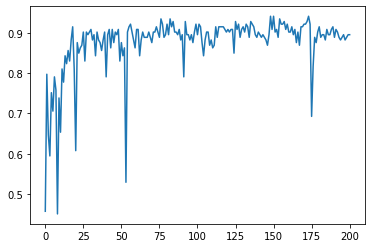

Epoch:  201
Accuracy : 0.8888888888888888
Average prediction time 0.20368653728115943 31
Epoch:  202
Accuracy : 0.8888888888888888
Average prediction time 0.20336185732195455 31
Epoch:  203
Accuracy : 0.9084967320261438
Average prediction time 0.20340068878666048 31
Epoch:  204
Accuracy : 0.9019607843137255
Average prediction time 0.20311867037127096 31
Epoch:  205
Accuracy : 0.9019607843137255
Average prediction time 0.20317484486487605 31
Epoch:  206
Accuracy : 0.8888888888888888
Average prediction time 0.20318866545154202 31
Epoch:  207
Accuracy : 0.8823529411764706
Average prediction time 0.2032565224555231 31
Epoch:  208
Accuracy : 0.7254901960784313
Average prediction time 0.20326757431030273 31
Epoch:  209
Accuracy : 0.8888888888888888
Average prediction time 0.20353524915633664 31
Epoch:  210
Accuracy : 0.8888888888888888
Average prediction time 0.20336628729297268 31
Epoch:  211
Accuracy : 0.8954248366013072
Average prediction time 0.20316808454452023 31
Epoch:  212
Accuracy :

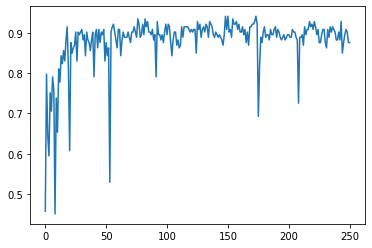

Epoch:  251
Accuracy : 0.8823529411764706
Average prediction time 0.2035995760271626 31
Epoch:  252
Accuracy : 0.8954248366013072
Average prediction time 0.20342158502148044 31
Epoch:  253
Accuracy : 0.9281045751633987
Average prediction time 0.20311795511553365 31
Epoch:  254
Accuracy : 0.8954248366013072
Average prediction time 0.20324851620581844 31
Epoch:  255
Accuracy : 0.934640522875817
Average prediction time 0.20339702021691106 31
Epoch:  256
Accuracy : 0.9477124183006536
Average prediction time 0.20357028899654264 31
Epoch:  257
Accuracy : 0.934640522875817
Average prediction time 0.2032450476000386 31
Epoch:  258
Accuracy : 0.9150326797385621
Average prediction time 0.2033939669209142 31
Epoch:  259
Accuracy : 0.9084967320261438
Average prediction time 0.20315594826975175 31
Epoch:  260
Accuracy : 0.9084967320261438
Average prediction time 0.20350007087953628 31
Epoch:  261
Accuracy : 0.8758169934640523
Average prediction time 0.20328216398915938 31
Epoch:  262
Accuracy : 0.9

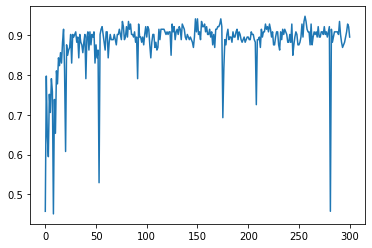

Epoch:  301
Accuracy : 0.8954248366013072
Average prediction time 0.2034785593709638 31
Epoch:  302
Accuracy : 0.8888888888888888
Average prediction time 0.20355426111528951 31
Epoch:  303
Accuracy : 0.9281045751633987
Average prediction time 0.20318245887756348 31
Epoch:  304
Accuracy : 0.9281045751633987
Average prediction time 0.20318891156104305 31
Epoch:  305
Accuracy : 0.9477124183006536
Average prediction time 0.20352476642977807 31
Epoch:  306
Accuracy : 0.9150326797385621
Average prediction time 0.20307024832694762 31
Epoch:  307
Accuracy : 0.9084967320261438
Average prediction time 0.20324041766505088 31
Epoch:  308
Accuracy : 0.9215686274509803
Average prediction time 0.203556852955972 31
Epoch:  309
Accuracy : 0.9281045751633987
Average prediction time 0.2032398716095955 31
Epoch:  310
Accuracy : 0.8954248366013072
Average prediction time 0.20330227574994486 31
Epoch:  311
Accuracy : 0.8823529411764706
Average prediction time 0.20327401161193848 31
Epoch:  312
Accuracy : 0.

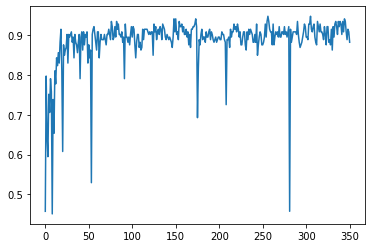

Epoch:  351
Accuracy : 0.9150326797385621
Average prediction time 0.20334256848981302 31
Epoch:  352
Accuracy : 0.9084967320261438
Average prediction time 0.2033145889159172 31
Epoch:  353
Accuracy : 0.9215686274509803
Average prediction time 0.20319389527843845 31
Epoch:  354
Accuracy : 0.9019607843137255
Average prediction time 0.20311156395942934 31
Epoch:  355
Accuracy : 0.9215686274509803
Average prediction time 0.20334129179677657 31
Epoch:  356
Accuracy : 0.9215686274509803
Average prediction time 0.20316399297406595 31
Epoch:  357
Accuracy : 0.9150326797385621
Average prediction time 0.20309222129083448 31
Epoch:  358
Accuracy : 0.9150326797385621
Average prediction time 0.20308453805984988 31
Epoch:  359
Accuracy : 0.9150326797385621
Average prediction time 0.2032157221148091 31
Epoch:  360
Accuracy : 0.9150326797385621
Average prediction time 0.20324857004227176 31
Epoch:  361
Accuracy : 0.9150326797385621
Average prediction time 0.20338874478493968 31
Epoch:  362
Accuracy : 

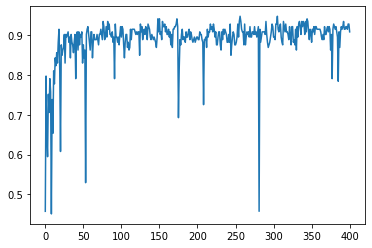

Epoch:  401
Accuracy : 0.9150326797385621
Average prediction time 0.2033006529654226 31
Epoch:  402
Accuracy : 0.9150326797385621
Average prediction time 0.20325165410195628 31
Epoch:  403
Accuracy : 0.9084967320261438
Average prediction time 0.2033872219824022 31
Epoch:  404
Accuracy : 0.9150326797385621
Average prediction time 0.2033717247747606 31
Epoch:  405
Accuracy : 0.934640522875817
Average prediction time 0.2034709838128859 31
Epoch:  406
Accuracy : 0.8954248366013072
Average prediction time 0.20322711237015262 31
Epoch:  407
Accuracy : 0.9150326797385621
Average prediction time 0.2033094129254741 31
Epoch:  408
Accuracy : 0.8954248366013072
Average prediction time 0.20302426430486864 31
Epoch:  409
Accuracy : 0.8888888888888888
Average prediction time 0.20342026987383444 31
Epoch:  410
Accuracy : 0.9019607843137255
Average prediction time 0.20314828811153288 31
Epoch:  411
Accuracy : 0.8758169934640523
Average prediction time 0.203228973573254 31
Epoch:  412
Accuracy : 0.8888

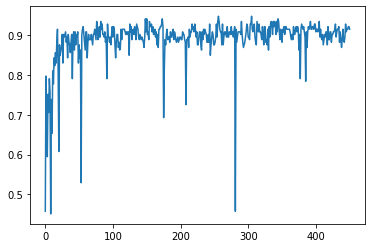

Epoch:  451
Accuracy : 0.9281045751633987
Average prediction time 0.20324297105112382 31
Epoch:  452
Accuracy : 0.9281045751633987
Average prediction time 0.20321033846947453 31
Epoch:  453
Accuracy : 0.9281045751633987
Average prediction time 0.2032461089472617 31
Epoch:  454
Accuracy : 0.8823529411764706
Average prediction time 0.20353275729763892 31
Epoch:  455
Accuracy : 0.8562091503267973
Average prediction time 0.2031152709837883 31
Epoch:  456
Accuracy : 0.9281045751633987
Average prediction time 0.20319599490011891 31
Epoch:  457
Accuracy : 0.9215686274509803
Average prediction time 0.20368323018473963 31
Epoch:  458
Accuracy : 0.9215686274509803
Average prediction time 0.203253569141511 31
Epoch:  459
Accuracy : 0.9281045751633987
Average prediction time 0.2034498030139554 31
Epoch:  460
Accuracy : 0.9215686274509803
Average prediction time 0.20328079500506002 31
Epoch:  461
Accuracy : 0.9215686274509803
Average prediction time 0.203281371824203 31
Epoch:  462
Accuracy : 0.915

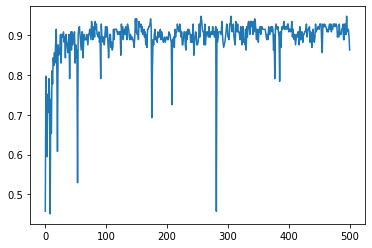

Epoch:  501
Accuracy : 0.8758169934640523
Average prediction time 0.20339545895976405 31
Epoch:  502
Accuracy : 0.9084967320261438
Average prediction time 0.20330898992476926 31
Epoch:  503
Accuracy : 0.9084967320261438
Average prediction time 0.20327311177407542 31
Epoch:  504
Accuracy : 0.9084967320261438
Average prediction time 0.2034358286088513 31
Epoch:  505
Accuracy : 0.9084967320261438
Average prediction time 0.20315181824468798 31
Epoch:  506
Accuracy : 0.8758169934640523
Average prediction time 0.20321219967257592 31
Epoch:  507
Accuracy : 0.9019607843137255
Average prediction time 0.20352437419276084 31
Epoch:  508
Accuracy : 0.9150326797385621
Average prediction time 0.20316354690059538 31
Epoch:  509
Accuracy : 0.9281045751633987
Average prediction time 0.20314215075585149 31
Epoch:  510
Accuracy : 0.9477124183006536
Average prediction time 0.2036494824194139 31
Epoch:  511
Accuracy : 0.934640522875817
Average prediction time 0.20308588397118352 31
Epoch:  512
Accuracy : 0

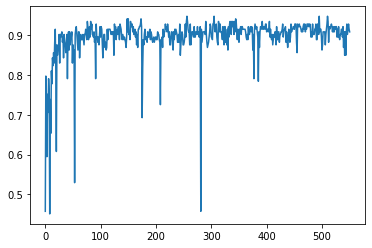

Epoch:  551
Accuracy : 0.9084967320261438
Average prediction time 0.2032462320020122 31
Epoch:  552
Accuracy : 0.9150326797385621
Average prediction time 0.20312055464713805 31
Epoch:  553
Accuracy : 0.9084967320261438
Average prediction time 0.20320599309859738 31
Epoch:  554
Accuracy : 0.9215686274509803
Average prediction time 0.20322312847260507 31
Epoch:  555
Accuracy : 0.9084967320261438
Average prediction time 0.20334566024041945 31
Epoch:  556
Accuracy : 0.9084967320261438
Average prediction time 0.2033045599537511 31
Epoch:  557
Accuracy : 0.9215686274509803
Average prediction time 0.20324735487661055 31
Epoch:  558
Accuracy : 0.8888888888888888
Average prediction time 0.20324042535597278 31
Epoch:  559
Accuracy : 0.8823529411764706
Average prediction time 0.20337912344163464 31
Epoch:  560
Accuracy : 0.8758169934640523
Average prediction time 0.20319592568182177 31
Epoch:  561
Accuracy : 0.8758169934640523
Average prediction time 0.20311214077857234 31
Epoch:  562
Accuracy : 

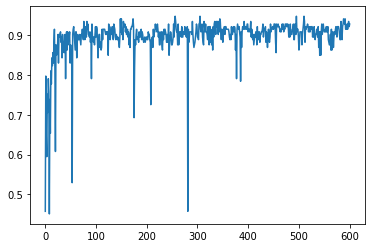

Epoch:  601
Accuracy : 0.9215686274509803
Average prediction time 0.20331819595829134 31
Epoch:  602
Accuracy : 0.9084967320261438
Average prediction time 0.20354013289174727 31
Epoch:  603
Accuracy : 0.8888888888888888
Average prediction time 0.20335867328028526 31
Epoch:  604
Accuracy : 0.9019607843137255
Average prediction time 0.2032882398174655 31
Epoch:  605
Accuracy : 0.869281045751634
Average prediction time 0.20320527784286008 31
Epoch:  606
Accuracy : 0.8888888888888888
Average prediction time 0.20329904556274414 31
Epoch:  607
Accuracy : 0.8888888888888888
Average prediction time 0.20312020855565224 31
Epoch:  608
Accuracy : 0.9084967320261438
Average prediction time 0.20323742589642924 31
Epoch:  609
Accuracy : 0.8954248366013072
Average prediction time 0.20329984541862242 31
Epoch:  610
Accuracy : 0.9150326797385621
Average prediction time 0.2031358749635758 31
Epoch:  611
Accuracy : 0.9281045751633987
Average prediction time 0.20332947854072816 31
Epoch:  612
Accuracy : 0

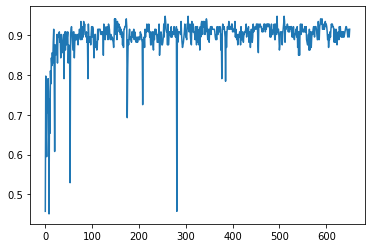

Epoch:  651
Accuracy : 0.9084967320261438
Average prediction time 0.20318518146391837 31
Epoch:  652
Accuracy : 0.9150326797385621
Average prediction time 0.20319047281819005 31
Epoch:  653
Accuracy : 0.9019607843137255
Average prediction time 0.20325136953784573 31
Epoch:  654
Accuracy : 0.9019607843137255
Average prediction time 0.203356227567119 31
Epoch:  655
Accuracy : 0.8888888888888888
Average prediction time 0.20329632297638925 31
Epoch:  656
Accuracy : 0.9019607843137255
Average prediction time 0.20359465383714245 31
Epoch:  657
Accuracy : 0.9019607843137255
Average prediction time 0.20341345571702527 31
Epoch:  658
Accuracy : 0.9084967320261438
Average prediction time 0.20332851717548986 31
Epoch:  659
Accuracy : 0.8888888888888888
Average prediction time 0.20325490736192273 31
Epoch:  660
Accuracy : 0.9084967320261438
Average prediction time 0.20339852763760474 31
Epoch:  661
Accuracy : 0.8169934640522876
Average prediction time 0.2032026090929585 31
Epoch:  662
Accuracy : 0

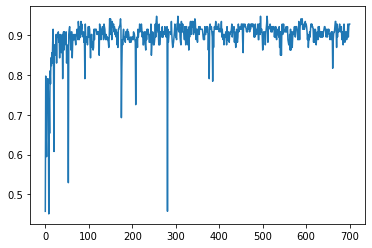

Epoch:  701
Accuracy : 0.9019607843137255
Average prediction time 0.20351016905999952 31
Epoch:  702
Accuracy : 0.9281045751633987
Average prediction time 0.20379015707200573 31
Epoch:  703
Accuracy : 0.934640522875817
Average prediction time 0.20349637154609926 31
Epoch:  704
Accuracy : 0.9150326797385621
Average prediction time 0.20549357321954542 31
Epoch:  705
Accuracy : 0.9215686274509803
Average prediction time 0.20345001066884688 31
Epoch:  706
Accuracy : 0.9150326797385621
Average prediction time 0.2036112739193824 31
Epoch:  707
Accuracy : 0.9150326797385621
Average prediction time 0.20352740441599199 31
Epoch:  708
Accuracy : 0.9215686274509803
Average prediction time 0.20349362588697864 31
Epoch:  709
Accuracy : 0.9411764705882353
Average prediction time 0.20449566072033298 31
Epoch:  710
Accuracy : 0.9411764705882353
Average prediction time 0.20340383437372023 31
Epoch:  711
Accuracy : 0.934640522875817
Average prediction time 0.20483699152546544 31
Epoch:  712
Accuracy : 0

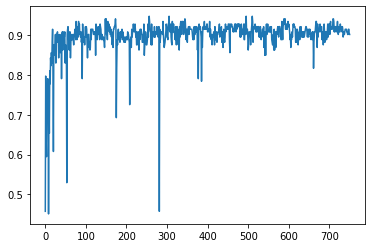

Epoch:  751
Accuracy : 0.9084967320261438
Average prediction time 0.20701433766272762 31
Epoch:  752
Accuracy : 0.9019607843137255
Average prediction time 0.20435723181693785 31
Epoch:  753
Accuracy : 0.934640522875817
Average prediction time 0.20485509595563334 31
Epoch:  754
Accuracy : 0.934640522875817
Average prediction time 0.20475372191398375 31
Epoch:  755
Accuracy : 0.9150326797385621
Average prediction time 0.2046350202252788 31
Epoch:  756
Accuracy : 0.9019607843137255
Average prediction time 0.20444346243335354 31
Epoch:  757
Accuracy : 0.8888888888888888
Average prediction time 0.2044613899723176 31
Epoch:  758
Accuracy : 0.9150326797385621
Average prediction time 0.20517390774142358 31
Epoch:  759
Accuracy : 0.9150326797385621
Average prediction time 0.20466143085110572 31
Epoch:  760
Accuracy : 0.9150326797385621
Average prediction time 0.20452803181063745 31
Epoch:  761
Accuracy : 0.9084967320261438
Average prediction time 0.2044863470139042 31
Epoch:  762
Accuracy : 0.9

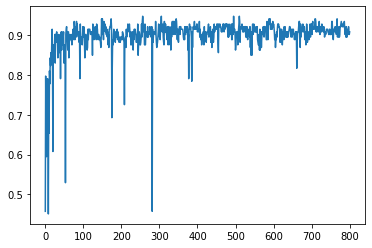

Epoch:  801
Accuracy : 0.8954248366013072
Average prediction time 0.20358007954012963 31
Epoch:  802
Accuracy : 0.9150326797385621
Average prediction time 0.2036421683526808 31
Epoch:  803
Accuracy : 0.9019607843137255
Average prediction time 0.2040320058022776 31
Epoch:  804
Accuracy : 0.9150326797385621
Average prediction time 0.20339828921902564 31
Epoch:  805
Accuracy : 0.934640522875817
Average prediction time 0.2034664615508049 31
Epoch:  806
Accuracy : 0.934640522875817
Average prediction time 0.2038160370242211 31
Epoch:  807
Accuracy : 0.9281045751633987
Average prediction time 0.20416718913662818 31
Epoch:  808
Accuracy : 0.9150326797385621
Average prediction time 0.20333322401969664 31
Epoch:  809
Accuracy : 0.934640522875817
Average prediction time 0.20338493008767405 31
Epoch:  810
Accuracy : 0.8888888888888888
Average prediction time 0.20327791090934508 31
Epoch:  811
Accuracy : 0.9281045751633987
Average prediction time 0.2038174675356957 31
Epoch:  812
Accuracy : 0.9084

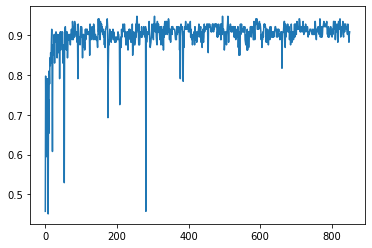

Epoch:  851
Accuracy : 0.9019607843137255
Average prediction time 0.20370019635846537 31
Epoch:  852
Accuracy : 0.9411764705882353
Average prediction time 0.2036099741535802 31
Epoch:  853
Accuracy : 0.9215686274509803
Average prediction time 0.20335432790940808 31
Epoch:  854
Accuracy : 0.8758169934640523
Average prediction time 0.2035339186268468 31
Epoch:  855
Accuracy : 0.9281045751633987
Average prediction time 0.20346713066101074 31
Epoch:  856
Accuracy : 0.9281045751633987
Average prediction time 0.20333845384659305 31
Epoch:  857
Accuracy : 0.9150326797385621
Average prediction time 0.203506100562311 31
Epoch:  858
Accuracy : 0.9215686274509803
Average prediction time 0.20344808024744834 31
Epoch:  859
Accuracy : 0.9084967320261438
Average prediction time 0.20357501891351515 31
Epoch:  860
Accuracy : 0.934640522875817
Average prediction time 0.2033635954703054 31
Epoch:  861
Accuracy : 0.8954248366013072
Average prediction time 0.20355305364055018 31
Epoch:  862
Accuracy : 0.92

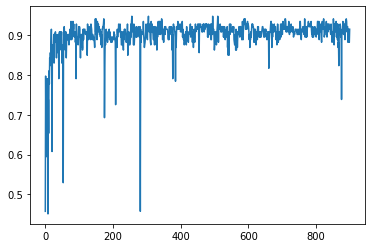

Epoch:  901
Accuracy : 0.9281045751633987
Average prediction time 0.20365884996229602 31
Epoch:  902
Accuracy : 0.9150326797385621
Average prediction time 0.2035919620144752 31
Epoch:  903
Accuracy : 0.9084967320261438
Average prediction time 0.20375064111525013 31
Epoch:  904
Accuracy : 0.9411764705882353
Average prediction time 0.20352765821641491 31
Epoch:  905
Accuracy : 0.9411764705882353
Average prediction time 0.2035022012649044 31
Epoch:  906
Accuracy : 0.9084967320261438
Average prediction time 0.2035045931416173 31
Epoch:  907
Accuracy : 0.9411764705882353
Average prediction time 0.20329219295132545 31
Epoch:  908
Accuracy : 0.9215686274509803
Average prediction time 0.20357292698275659 31
Epoch:  909
Accuracy : 0.9150326797385621
Average prediction time 0.203518190691548 31
Epoch:  910
Accuracy : 0.934640522875817
Average prediction time 0.2034241537893972 31
Epoch:  911
Accuracy : 0.9215686274509803
Average prediction time 0.2035142837032195 31
Epoch:  912
Accuracy : 0.9281

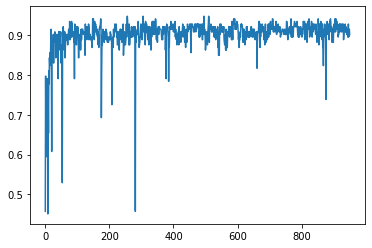

Epoch:  951
Accuracy : 0.8954248366013072
Average prediction time 0.20339713558073966 31
Epoch:  952
Accuracy : 0.8627450980392157
Average prediction time 0.20343818972187658 31
Epoch:  953
Accuracy : 0.8954248366013072
Average prediction time 0.20354050205599877 31
Epoch:  954
Accuracy : 0.8888888888888888
Average prediction time 0.2037097023379418 31
Epoch:  955
Accuracy : 0.9215686274509803
Average prediction time 0.2036690865793536 31
Epoch:  956
Accuracy : 0.8954248366013072
Average prediction time 0.2034847197994109 31
Epoch:  957
Accuracy : 0.9019607843137255
Average prediction time 0.20344405789529124 31
Epoch:  958
Accuracy : 0.9084967320261438
Average prediction time 0.203488742151568 31
Epoch:  959
Accuracy : 0.9084967320261438
Average prediction time 0.20333397773004347 31
Epoch:  960
Accuracy : 0.9084967320261438
Average prediction time 0.20345684789842175 31
Epoch:  961
Accuracy : 0.9150326797385621
Average prediction time 0.2033501055932814 31
Epoch:  962
Accuracy : 0.91

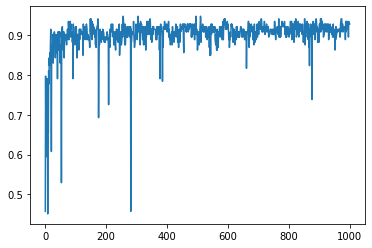

Epoch:  1001
Accuracy : 0.9477124183006536
Average prediction time 0.20326607458053098 31
Epoch:  1002
Accuracy : 0.9411764705882353
Average prediction time 0.2034562018609816 31
Epoch:  1003
Accuracy : 0.8823529411764706
Average prediction time 0.20423423090288717 31
Epoch:  1004
Accuracy : 0.934640522875817
Average prediction time 0.20336506443638955 31
Epoch:  1005
Accuracy : 0.9215686274509803
Average prediction time 0.20347235279698525 31
Epoch:  1006
Accuracy : 0.9150326797385621
Average prediction time 0.20348794229568973 31
Epoch:  1007
Accuracy : 0.9084967320261438
Average prediction time 0.203685914316485 31
Epoch:  1008
Accuracy : 0.9084967320261438
Average prediction time 0.20382811177161433 31
Epoch:  1009
Accuracy : 0.9150326797385621
Average prediction time 0.20343612855480564 31
Epoch:  1010
Accuracy : 0.8954248366013072
Average prediction time 0.20319104194641113 31
Epoch:  1011
Accuracy : 0.9019607843137255
Average prediction time 0.2034191931447675 31
Epoch:  1012
Ac

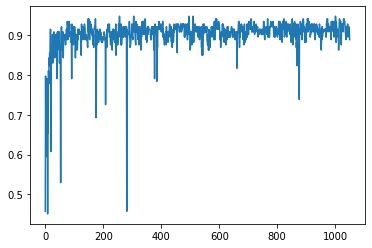

Epoch:  1051
Accuracy : 0.9084967320261438
Average prediction time 0.20357756460866622 31
Epoch:  1052
Accuracy : 0.9084967320261438
Average prediction time 0.20383299550702494 31
Epoch:  1053
Accuracy : 0.9215686274509803
Average prediction time 0.20329633835823305 31
Epoch:  1054
Accuracy : 0.9084967320261438
Average prediction time 0.20353524915633664 31
Epoch:  1055
Accuracy : 0.9019607843137255
Average prediction time 0.2033848762512207 31
Epoch:  1056
Accuracy : 0.9019607843137255
Average prediction time 0.20341877783498458 31
Epoch:  1057
Accuracy : 0.8954248366013072
Average prediction time 0.20324523218216434 31
Epoch:  1058
Accuracy : 0.9084967320261438
Average prediction time 0.2035948384192682 31
Epoch:  1059
Accuracy : 0.9084967320261438
Average prediction time 0.2033448911482288 31
Epoch:  1060
Accuracy : 0.9411764705882353
Average prediction time 0.20347554452957645 31
Epoch:  1061
Accuracy : 0.934640522875817
Average prediction time 0.20361031255414408 31
Epoch:  1062
A

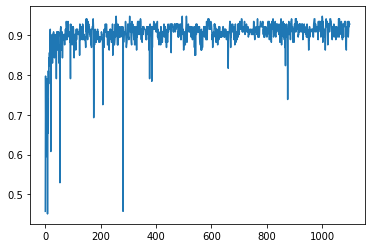

Epoch:  1101
Accuracy : 0.9411764705882353
Average prediction time 0.20336056524707424 31
Epoch:  1102
Accuracy : 0.9477124183006536
Average prediction time 0.2035577835575227 31
Epoch:  1103
Accuracy : 0.9411764705882353
Average prediction time 0.20359858389823668 31
Epoch:  1104
Accuracy : 0.9281045751633987
Average prediction time 0.20361231219383977 31
Epoch:  1105
Accuracy : 0.9281045751633987
Average prediction time 0.20372516878189578 31
Epoch:  1106
Accuracy : 0.9281045751633987
Average prediction time 0.20332367189468875 31
Epoch:  1107
Accuracy : 0.9215686274509803
Average prediction time 0.20344169678226595 31
Epoch:  1108
Accuracy : 0.9281045751633987
Average prediction time 0.20361535010799284 31
Epoch:  1109
Accuracy : 0.9411764705882353
Average prediction time 0.20330051452882827 31
Epoch:  1110
Accuracy : 0.9411764705882353
Average prediction time 0.20343850504967473 31
Epoch:  1111
Accuracy : 0.9411764705882353
Average prediction time 0.20319403371503275 31
Epoch:  111

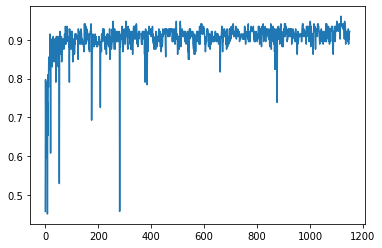

Epoch:  1151
Accuracy : 0.9215686274509803
Average prediction time 0.2035584911223381 31
Epoch:  1152
Accuracy : 0.9281045751633987
Average prediction time 0.20375774752709172 31
Epoch:  1153
Accuracy : 0.9150326797385621
Average prediction time 0.20334063806841451 31
Epoch:  1154
Accuracy : 0.8888888888888888
Average prediction time 0.2035426939687421 31
Epoch:  1155
Accuracy : 0.8888888888888888
Average prediction time 0.20377386000848585 31
Epoch:  1156
Accuracy : 0.9019607843137255
Average prediction time 0.20359689958633914 31
Epoch:  1157
Accuracy : 0.9150326797385621
Average prediction time 0.2033932670470207 31
Epoch:  1158
Accuracy : 0.8954248366013072
Average prediction time 0.2035782644825597 31
Epoch:  1159
Accuracy : 0.9084967320261438
Average prediction time 0.2036267403633364 31
Epoch:  1160
Accuracy : 0.9084967320261438
Average prediction time 0.20349483336171797 31
Epoch:  1161
Accuracy : 0.8954248366013072
Average prediction time 0.20330629810210196 31
Epoch:  1162
Ac

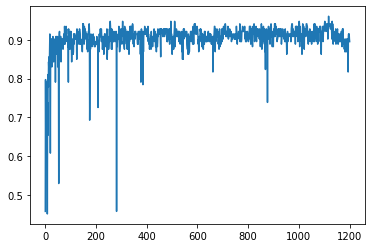

Epoch:  1201
Accuracy : 0.9019607843137255
Average prediction time 0.20377656721299695 31
Epoch:  1202
Accuracy : 0.9084967320261438
Average prediction time 0.2033246870963804 31
Epoch:  1203
Accuracy : 0.8758169934640523
Average prediction time 0.20365725025053946 31
Epoch:  1204
Accuracy : 0.9019607843137255
Average prediction time 0.20356258269279234 31
Epoch:  1205
Accuracy : 0.8888888888888888
Average prediction time 0.20367873099542433 31
Epoch:  1206
Accuracy : 0.8823529411764706
Average prediction time 0.20315299495573966 31
Epoch:  1207
Accuracy : 0.8823529411764706
Average prediction time 0.20357311156488234 31
Epoch:  1208
Accuracy : 0.9084967320261438
Average prediction time 0.2034359901182113 31
Epoch:  1209
Accuracy : 0.9281045751633987
Average prediction time 0.20343380589638987 31
Epoch:  1210
Accuracy : 0.934640522875817
Average prediction time 0.20363131646187074 31
Epoch:  1211
Accuracy : 0.9150326797385621
Average prediction time 0.20341108691307805 31
Epoch:  1212


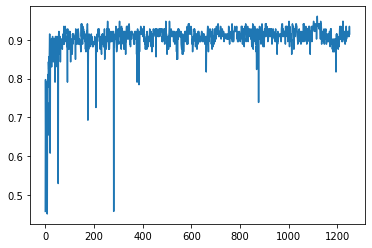

Epoch:  1251
Accuracy : 0.9150326797385621
Average prediction time 0.20351250710025912 31
Epoch:  1252
Accuracy : 0.9084967320261438
Average prediction time 0.20336244952294133 31
Epoch:  1253
Accuracy : 0.9215686274509803
Average prediction time 0.20322342841855942 31
Epoch:  1254
Accuracy : 0.934640522875817
Average prediction time 0.20349591009078488 31
Epoch:  1255
Accuracy : 0.9411764705882353
Average prediction time 0.20360027590105612 31
Epoch:  1256
Accuracy : 0.9281045751633987
Average prediction time 0.20354217098605248 31
Epoch:  1257
Accuracy : 0.934640522875817
Average prediction time 0.2033389768292827 31
Epoch:  1258
Accuracy : 0.9150326797385621
Average prediction time 0.20344900315807712 31
Epoch:  1259
Accuracy : 0.9019607843137255
Average prediction time 0.20332900170356996 31
Epoch:  1260
Accuracy : 0.9150326797385621
Average prediction time 0.20340389590109548 31
Epoch:  1261
Accuracy : 0.9019607843137255
Average prediction time 0.2033952897594821 31
Epoch:  1262
A

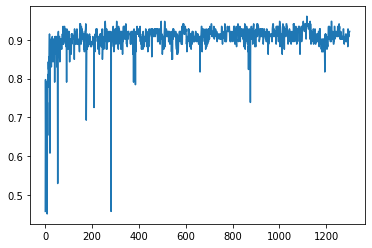

Epoch:  1301
Accuracy : 0.8823529411764706
Average prediction time 0.20342979123515467 31
Epoch:  1302
Accuracy : 0.8954248366013072
Average prediction time 0.2034269840486588 31
Epoch:  1303
Accuracy : 0.8823529411764706
Average prediction time 0.2034056032857587 31
Epoch:  1304
Accuracy : 0.9281045751633987
Average prediction time 0.20362337173954134 31
Epoch:  1305
Accuracy : 0.9084967320261438
Average prediction time 0.20342954512565367 31
Epoch:  1306
Accuracy : 0.9150326797385621
Average prediction time 0.20327473455859768 31
Epoch:  1307
Accuracy : 0.9215686274509803
Average prediction time 0.2034195392362533 31
Epoch:  1308
Accuracy : 0.9281045751633987
Average prediction time 0.2037851425909227 31
Epoch:  1309
Accuracy : 0.9281045751633987
Average prediction time 0.2032788876564272 31
Epoch:  1310
Accuracy : 0.9215686274509803
Average prediction time 0.20345640951587307 31
Epoch:  1311
Accuracy : 0.9281045751633987
Average prediction time 0.20338661439957156 31
Epoch:  1312
Ac

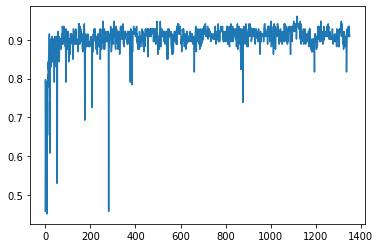

Epoch:  1351
Accuracy : 0.9084967320261438
Average prediction time 0.20346877651829873 31
Epoch:  1352
Accuracy : 0.8954248366013072
Average prediction time 0.2033711325737738 31
Epoch:  1353
Accuracy : 0.9281045751633987
Average prediction time 0.2033581502975956 31
Epoch:  1354
Accuracy : 0.934640522875817
Average prediction time 0.20363933040249732 31
Epoch:  1355
Accuracy : 0.8954248366013072
Average prediction time 0.20364027638589183 31
Epoch:  1356
Accuracy : 0.934640522875817
Average prediction time 0.20365460457340365 31
Epoch:  1357
Accuracy : 0.9150326797385621
Average prediction time 0.2035068235089702 31
Epoch:  1358
Accuracy : 0.934640522875817
Average prediction time 0.2035679740290488 31
Epoch:  1359
Accuracy : 0.9215686274509803
Average prediction time 0.20332541004303964 31
Epoch:  1360
Accuracy : 0.9150326797385621
Average prediction time 0.20341648594025644 31
Epoch:  1361
Accuracy : 0.9084967320261438
Average prediction time 0.20350323953936178 31
Epoch:  1362
Accu

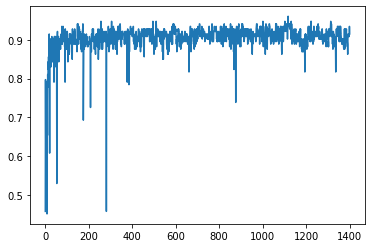

Epoch:  1401
Accuracy : 0.934640522875817
Average prediction time 0.20358321743626748 31
Epoch:  1402
Accuracy : 0.9477124183006536
Average prediction time 0.20343321369540307 31
Epoch:  1403
Accuracy : 0.9477124183006536
Average prediction time 0.2033431145452684 31
Epoch:  1404
Accuracy : 0.9084967320261438
Average prediction time 0.20353365713550198 31
Epoch:  1405
Accuracy : 0.9215686274509803
Average prediction time 0.2032134686746905 31
Epoch:  1406
Accuracy : 0.934640522875817
Average prediction time 0.20354118654804845 31
Epoch:  1407
Accuracy : 0.8888888888888888
Average prediction time 0.20346396200118527 31
Epoch:  1408
Accuracy : 0.9215686274509803
Average prediction time 0.2033210108357091 31
Epoch:  1409
Accuracy : 0.9215686274509803
Average prediction time 0.20344456549613707 31
Epoch:  1410
Accuracy : 0.9150326797385621
Average prediction time 0.20329145462282242 31
Epoch:  1411
Accuracy : 0.9281045751633987
Average prediction time 0.20361738051137618 31
Epoch:  1412
Ac

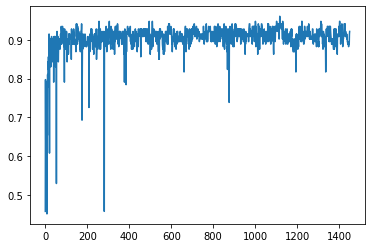

Epoch:  1451
Accuracy : 0.9150326797385621
Average prediction time 0.2036031061603177 31
Epoch:  1452
Accuracy : 0.9084967320261438
Average prediction time 0.20381163012596867 31
Epoch:  1453
Accuracy : 0.9019607843137255
Average prediction time 0.2034426043110509 31
Epoch:  1454
Accuracy : 0.9215686274509803
Average prediction time 0.20360859747855894 31
Epoch:  1455
Accuracy : 0.9411764705882353
Average prediction time 0.2033103819816343 31
Epoch:  1456
Accuracy : 0.9019607843137255
Average prediction time 0.20335415870912613 31
Epoch:  1457
Accuracy : 0.9019607843137255
Average prediction time 0.20381719835342899 31
Epoch:  1458
Accuracy : 0.934640522875817
Average prediction time 0.20342916057955834 31
Epoch:  1459
Accuracy : 0.8496732026143791
Average prediction time 0.20346176239752 31
Epoch:  1460
Accuracy : 0.8562091503267973
Average prediction time 0.20330367549773184 31
Epoch:  1461
Accuracy : 0.8888888888888888
Average prediction time 0.20338140764544088 31
Epoch:  1462
Accu

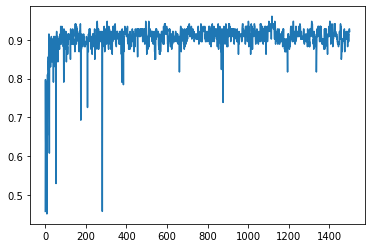

Epoch:  1501
Accuracy : 0.934640522875817
Average prediction time 0.2032502620450912 31
Epoch:  1502
Accuracy : 0.934640522875817
Average prediction time 0.20336954055293913 31
Epoch:  1503
Accuracy : 0.9019607843137255
Average prediction time 0.20361194302958827 31
Epoch:  1504
Accuracy : 0.9411764705882353
Average prediction time 0.20392138727249637 31
Epoch:  1505
Accuracy : 0.934640522875817
Average prediction time 0.20327787245473555 31
Epoch:  1506
Accuracy : 0.9150326797385621
Average prediction time 0.20384852347835417 31
Epoch:  1507
Accuracy : 0.9477124183006536
Average prediction time 0.20338201522827148 31
Epoch:  1508
Accuracy : 0.9411764705882353
Average prediction time 0.20324773173178395 31
Epoch:  1509
Accuracy : 0.9019607843137255
Average prediction time 0.20334995177484327 31
Epoch:  1510
Accuracy : 0.8758169934640523
Average prediction time 0.20351055360609485 31
Epoch:  1511
Accuracy : 0.9215686274509803
Average prediction time 0.20333605427895823 31
Epoch:  1512
A

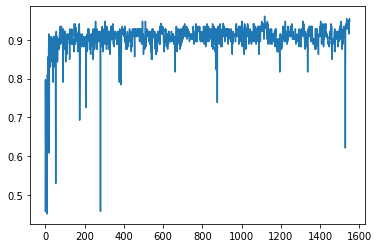

Epoch:  1551
Accuracy : 0.9477124183006536
Average prediction time 0.20346258532616399 31
Epoch:  1552
Accuracy : 0.9411764705882353
Average prediction time 0.20361573465408817 31
Epoch:  1553
Accuracy : 0.934640522875817
Average prediction time 0.20360882051529422 31
Epoch:  1554
Accuracy : 0.9411764705882353
Average prediction time 0.20350027853442776 31
Epoch:  1555
Accuracy : 0.934640522875817
Average prediction time 0.20348123581178726 31
Epoch:  1556
Accuracy : 0.934640522875817
Average prediction time 0.2034230924421741 31
Epoch:  1557
Accuracy : 0.954248366013072
Average prediction time 0.20414628521088632 31
Epoch:  1558
Accuracy : 0.9411764705882353
Average prediction time 0.20343752830259262 31
Epoch:  1559
Accuracy : 0.954248366013072
Average prediction time 0.20353867930750694 31
Epoch:  1560
Accuracy : 0.9607843137254902
Average prediction time 0.2033736475052372 31
Epoch:  1561
Accuracy : 0.8888888888888888
Average prediction time 0.20333813082787297 31
Epoch:  1562
Accu

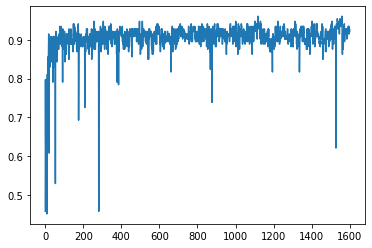

Epoch:  1601
Accuracy : 0.9281045751633987
Average prediction time 0.20347414478178946 31
Epoch:  1602
Accuracy : 0.934640522875817
Average prediction time 0.20348158959419496 31
Epoch:  1603
Accuracy : 0.9281045751633987
Average prediction time 0.20375351752004317 31
Epoch:  1604
Accuracy : 0.934640522875817
Average prediction time 0.20368179967326502 31
Epoch:  1605
Accuracy : 0.9215686274509803
Average prediction time 0.2034097102380568 31
Epoch:  1606
Accuracy : 0.9084967320261438
Average prediction time 0.2035174754358107 31
Epoch:  1607
Accuracy : 0.9215686274509803
Average prediction time 0.20332707128217142 31
Epoch:  1608
Accuracy : 0.9084967320261438
Average prediction time 0.20391558831737888 31
Epoch:  1609
Accuracy : 0.9215686274509803
Average prediction time 0.20328020280407322 31
Epoch:  1610
Accuracy : 0.934640522875817
Average prediction time 0.2036346773947439 31
Epoch:  1611
Accuracy : 0.9150326797385621
Average prediction time 0.20350085535357076 31
Epoch:  1612
Acc

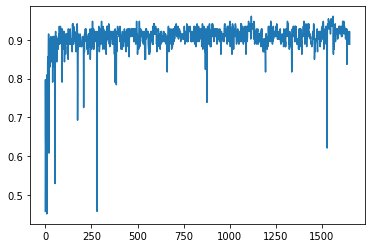

Epoch:  1651
Accuracy : 0.8888888888888888
Average prediction time 0.20317825963420252 31
Epoch:  1652
Accuracy : 0.8888888888888888
Average prediction time 0.20355433033358666 31
Epoch:  1653
Accuracy : 0.8823529411764706
Average prediction time 0.20334148406982422 31
Epoch:  1654
Accuracy : 0.8823529411764706
Average prediction time 0.20345820150067728 31
Epoch:  1655
Accuracy : 0.8823529411764706
Average prediction time 0.2035826329262026 31
Epoch:  1656
Accuracy : 0.8954248366013072
Average prediction time 0.20354687013933737 31
Epoch:  1657
Accuracy : 0.8758169934640523
Average prediction time 0.20343927414186538 31
Epoch:  1658
Accuracy : 0.8758169934640523
Average prediction time 0.20360780531360256 31
Epoch:  1659
Accuracy : 0.8758169934640523
Average prediction time 0.2035931541073707 31
Epoch:  1660
Accuracy : 0.8823529411764706
Average prediction time 0.2033491288461993 31
Epoch:  1661
Accuracy : 0.8758169934640523
Average prediction time 0.20399884254701675 31
Epoch:  1662


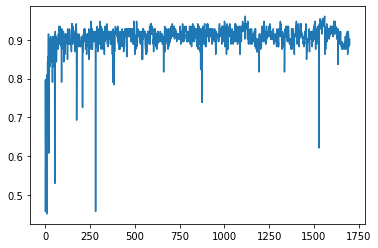

Epoch:  1701
Accuracy : 0.8627450980392157
Average prediction time 0.2035992068629111 31
Epoch:  1702
Accuracy : 0.8758169934640523
Average prediction time 0.20325290772222704 31
Epoch:  1703
Accuracy : 0.8888888888888888
Average prediction time 0.203581202414728 31
Epoch:  1704
Accuracy : 0.8954248366013072
Average prediction time 0.203861451918079 31
Epoch:  1705
Accuracy : 0.8954248366013072
Average prediction time 0.2036312395526517 31
Epoch:  1706
Accuracy : 0.8954248366013072
Average prediction time 0.2035265968691918 31
Epoch:  1707
Accuracy : 0.9019607843137255
Average prediction time 0.2034694610103484 31
Epoch:  1708
Accuracy : 0.8888888888888888
Average prediction time 0.20379943232382497 31
Epoch:  1709
Accuracy : 0.8888888888888888
Average prediction time 0.20350534685196414 31
Epoch:  1710
Accuracy : 0.9019607843137255
Average prediction time 0.20355383811458463 31
Epoch:  1711
Accuracy : 0.9019607843137255
Average prediction time 0.2034837507432507 31
Epoch:  1712
Accura

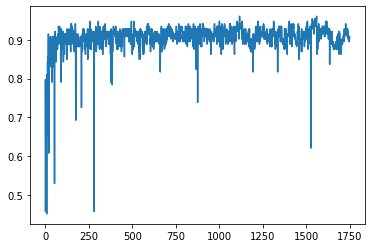

Epoch:  1751
Accuracy : 0.9084967320261438
Average prediction time 0.20369332836520287 31
Epoch:  1752
Accuracy : 0.934640522875817
Average prediction time 0.20393615384255687 31
Epoch:  1753
Accuracy : 0.9281045751633987
Average prediction time 0.20367782346663937 31
Epoch:  1754
Accuracy : 0.9215686274509803
Average prediction time 0.20336784855011972 31
Epoch:  1755
Accuracy : 0.9215686274509803
Average prediction time 0.20353924074480612 31
Epoch:  1756
Accuracy : 0.9281045751633987
Average prediction time 0.20369753529948573 31
Epoch:  1757
Accuracy : 0.869281045751634
Average prediction time 0.2035418325854886 31
Epoch:  1758
Accuracy : 0.9150326797385621
Average prediction time 0.20340697226985807 31
Epoch:  1759
Accuracy : 0.9150326797385621
Average prediction time 0.20382668895106162 31
Epoch:  1760
Accuracy : 0.9150326797385621
Average prediction time 0.20331085881879252 31
Epoch:  1761
Accuracy : 0.9215686274509803
Average prediction time 0.20332808648386308 31
Epoch:  1762


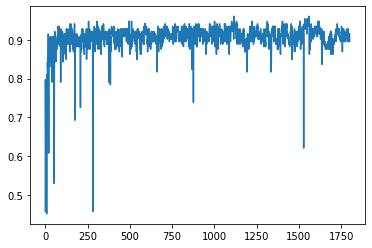

Epoch:  1801
Accuracy : 0.9150326797385621
Average prediction time 0.20367508549844066 31
Epoch:  1802
Accuracy : 0.9084967320261438
Average prediction time 0.20330829005087575 31
Epoch:  1803
Accuracy : 0.9215686274509803
Average prediction time 0.20353310338912473 31
Epoch:  1804
Accuracy : 0.9411764705882353
Average prediction time 0.20357514196826565 31
Epoch:  1805
Accuracy : 0.9215686274509803
Average prediction time 0.20326447486877441 31
Epoch:  1806
Accuracy : 0.9215686274509803
Average prediction time 0.20347295268889395 31
Epoch:  1807
Accuracy : 0.9281045751633987
Average prediction time 0.20362837852970248 31
Epoch:  1808
Accuracy : 0.9150326797385621
Average prediction time 0.20358990853832615 31
Epoch:  1809
Accuracy : 0.9019607843137255
Average prediction time 0.2033749165073518 31
Epoch:  1810
Accuracy : 0.8954248366013072
Average prediction time 0.20350120144505654 31
Epoch:  1811
Accuracy : 0.9019607843137255
Average prediction time 0.20330519830026933 31
Epoch:  181

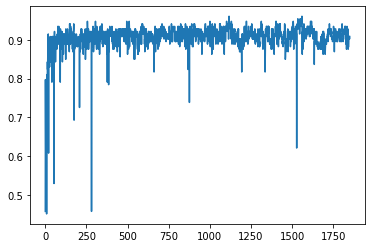

Epoch:  1851
Accuracy : 0.9019607843137255
Average prediction time 0.20353302647990565 31
Epoch:  1852
Accuracy : 0.8954248366013072
Average prediction time 0.20334532183985557 31
Epoch:  1853
Accuracy : 0.8954248366013072
Average prediction time 0.20341957769086283 31
Epoch:  1854
Accuracy : 0.9019607843137255
Average prediction time 0.2036595267634238 31
Epoch:  1855
Accuracy : 0.9084967320261438
Average prediction time 0.2033943207033219 31
Epoch:  1856
Accuracy : 0.9019607843137255
Average prediction time 0.20335998842793127 31
Epoch:  1857
Accuracy : 0.9019607843137255
Average prediction time 0.20343999708852462 31
Epoch:  1858
Accuracy : 0.9019607843137255
Average prediction time 0.20375351752004317 31
Epoch:  1859
Accuracy : 0.9084967320261438
Average prediction time 0.2038198055759553 31
Epoch:  1860
Accuracy : 0.9019607843137255
Average prediction time 0.20333030916029407 31
Epoch:  1861
Accuracy : 0.9084967320261438
Average prediction time 0.2037718834415559 31
Epoch:  1862
A

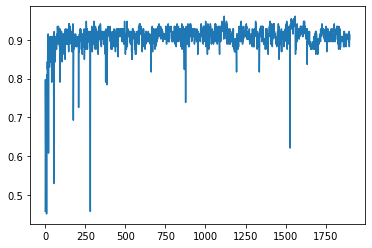

Epoch:  1901
Accuracy : 0.9215686274509803
Average prediction time 0.20375211777225619 31
Epoch:  1902
Accuracy : 0.869281045751634
Average prediction time 0.2034897804260254 31
Epoch:  1903
Accuracy : 0.9215686274509803
Average prediction time 0.20360959729840677 31
Epoch:  1904
Accuracy : 0.9150326797385621
Average prediction time 0.20384388585244456 31
Epoch:  1905
Accuracy : 0.9281045751633987
Average prediction time 0.20333939213906566 31
Epoch:  1906
Accuracy : 0.9215686274509803
Average prediction time 0.20354541655509703 31
Epoch:  1907
Accuracy : 0.8823529411764706
Average prediction time 0.20332406413170598 31
Epoch:  1908
Accuracy : 0.8954248366013072
Average prediction time 0.2034017885884931 31
Epoch:  1909
Accuracy : 0.9019607843137255
Average prediction time 0.20326878178504207 31
Epoch:  1910
Accuracy : 0.8954248366013072
Average prediction time 0.20343487493453488 31
Epoch:  1911
Accuracy : 0.9281045751633987
Average prediction time 0.20369116721614713 31
Epoch:  1912


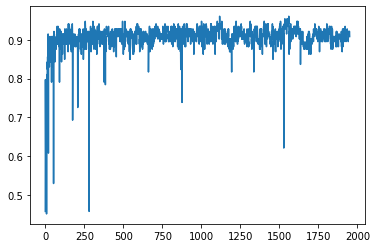

Epoch:  1951
Accuracy : 0.9281045751633987
Average prediction time 0.20338313041194792 31
Epoch:  1952
Accuracy : 0.8954248366013072
Average prediction time 0.20353160365935294 31
Epoch:  1953
Accuracy : 0.9084967320261438
Average prediction time 0.203457155535298 31
Epoch:  1954
Accuracy : 0.9084967320261438
Average prediction time 0.20361524243508616 31
Epoch:  1955
Accuracy : 0.9019607843137255
Average prediction time 0.2035420710040677 31
Epoch:  1956
Accuracy : 0.9150326797385621
Average prediction time 0.20359088528540828 31
Epoch:  1957
Accuracy : 0.9150326797385621
Average prediction time 0.20343902803236438 31
Epoch:  1958
Accuracy : 0.9150326797385621
Average prediction time 0.20319855597711378 31
Epoch:  1959
Accuracy : 0.9150326797385621
Average prediction time 0.20357454976727885 31
Epoch:  1960
Accuracy : 0.9019607843137255
Average prediction time 0.20331879585020005 31
Epoch:  1961
Accuracy : 0.9084967320261438
Average prediction time 0.20383887906228343 31
Epoch:  1962


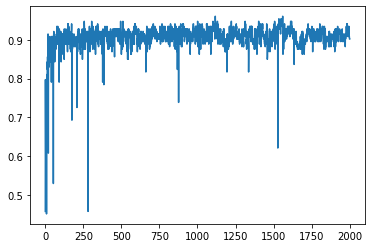

Epoch:  2001
Accuracy : 0.9019607843137255
Average prediction time 0.2032580683308263 31
Epoch:  2002
Accuracy : 0.9215686274509803
Average prediction time 0.20358176385202714 31
Epoch:  2003
Accuracy : 0.9281045751633987
Average prediction time 0.20367250134868006 31
Epoch:  2004
Accuracy : 0.934640522875817
Average prediction time 0.20351446828534525 31
Epoch:  2005
Accuracy : 0.9281045751633987
Average prediction time 0.2033560122213056 31
Epoch:  2006
Accuracy : 0.8496732026143791
Average prediction time 0.2034127866068194 31
Epoch:  2007
Accuracy : 0.869281045751634
Average prediction time 0.20330695952138594 31
Epoch:  2008
Accuracy : 0.9215686274509803
Average prediction time 0.20350494692402502 31
Epoch:  2009
Accuracy : 0.9019607843137255
Average prediction time 0.20421788000291394 31
Epoch:  2010
Accuracy : 0.9150326797385621
Average prediction time 0.20354687783025927 31
Epoch:  2011
Accuracy : 0.8888888888888888
Average prediction time 0.2034446039507466 31
Epoch:  2012
Acc

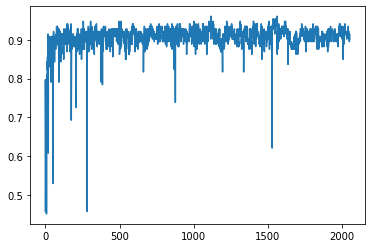

Epoch:  2051
Accuracy : 0.9084967320261438
Average prediction time 0.20363450819446194 31
Epoch:  2052
Accuracy : 0.9084967320261438
Average prediction time 0.20382819637175528 31
Epoch:  2053
Accuracy : 0.9084967320261438
Average prediction time 0.20366291076906265 31
Epoch:  2054
Accuracy : 0.8562091503267973
Average prediction time 0.20404747993715347 31
Epoch:  2055
Accuracy : 0.9215686274509803
Average prediction time 0.20331938036026492 31
Epoch:  2056
Accuracy : 0.9150326797385621
Average prediction time 0.2035807332684917 31
Epoch:  2057
Accuracy : 0.9281045751633987
Average prediction time 0.2038404095557428 31
Epoch:  2058
Accuracy : 0.9150326797385621
Average prediction time 0.2034665922964773 31
Epoch:  2059
Accuracy : 0.9150326797385621
Average prediction time 0.20354612411991244 31
Epoch:  2060
Accuracy : 0.9215686274509803
Average prediction time 0.2032670820913007 31
Epoch:  2061
Accuracy : 0.9215686274509803
Average prediction time 0.2036555044112667 31
Epoch:  2062
Ac

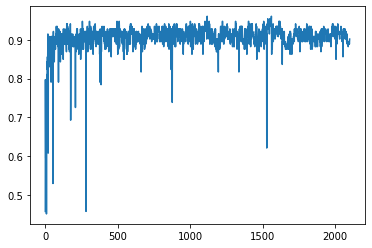

Epoch:  2101
Accuracy : 0.9019607843137255
Average prediction time 0.203365356691422 31
Epoch:  2102
Accuracy : 0.9019607843137255
Average prediction time 0.20395024361148958 31
Epoch:  2103
Accuracy : 0.9084967320261438
Average prediction time 0.2033828535387593 31
Epoch:  2104
Accuracy : 0.9019607843137255
Average prediction time 0.20323932555414015 31
Epoch:  2105
Accuracy : 0.9019607843137255
Average prediction time 0.20383905595348728 31
Epoch:  2106
Accuracy : 0.9150326797385621
Average prediction time 0.20378742679472892 31
Epoch:  2107
Accuracy : 0.9084967320261438
Average prediction time 0.2036956048780872 31
Epoch:  2108
Accuracy : 0.9019607843137255
Average prediction time 0.20363473123119724 31
Epoch:  2109
Accuracy : 0.9150326797385621
Average prediction time 0.2036539508450416 31
Epoch:  2110
Accuracy : 0.9019607843137255
Average prediction time 0.20352270526270713 31
Epoch:  2111
Accuracy : 0.9150326797385621
Average prediction time 0.20327742638126498 31
Epoch:  2112
Ac

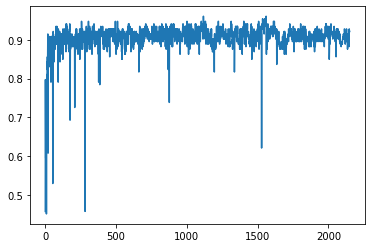

Epoch:  2151
Accuracy : 0.9281045751633987
Average prediction time 0.20339994276723555 31
Epoch:  2152
Accuracy : 0.9019607843137255
Average prediction time 0.20377035294809648 31
Epoch:  2153
Accuracy : 0.9215686274509803
Average prediction time 0.20357787224554247 31
Epoch:  2154
Accuracy : 0.9411764705882353
Average prediction time 0.20353668735873315 31
Epoch:  2155
Accuracy : 0.9281045751633987
Average prediction time 0.20335631985818187 31
Epoch:  2156
Accuracy : 0.934640522875817
Average prediction time 0.20339190575384325 31
Epoch:  2157
Accuracy : 0.934640522875817
Average prediction time 0.20358510171213456 31
Epoch:  2158
Accuracy : 0.934640522875817
Average prediction time 0.20343530562616163 31
Epoch:  2159
Accuracy : 0.9411764705882353
Average prediction time 0.20357641097038023 31
Epoch:  2160
Accuracy : 0.934640522875817
Average prediction time 0.20360687471205188 31
Epoch:  2161
Accuracy : 0.9281045751633987
Average prediction time 0.20358802426245906 31
Epoch:  2162
A

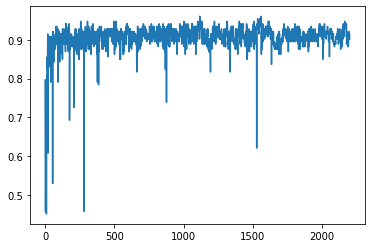

Epoch:  2201
Accuracy : 0.9150326797385621
Average prediction time 0.20356760486479727 31
Epoch:  2202
Accuracy : 0.9019607843137255
Average prediction time 0.20346290065396216 31
Epoch:  2203
Accuracy : 0.8823529411764706
Average prediction time 0.20382356643676758 31
Epoch:  2204
Accuracy : 0.8823529411764706
Average prediction time 0.20365143591357815 31
Epoch:  2205
Accuracy : 0.8954248366013072
Average prediction time 0.20357927968425135 31
Epoch:  2206
Accuracy : 0.9084967320261438
Average prediction time 0.20329055478495936 31
Epoch:  2207
Accuracy : 0.9150326797385621
Average prediction time 0.2038058234799293 31
Epoch:  2208
Accuracy : 0.9150326797385621
Average prediction time 0.20365329711667954 31
Epoch:  2209
Accuracy : 0.9084967320261438
Average prediction time 0.20349750211161952 31
Epoch:  2210
Accuracy : 0.9084967320261438
Average prediction time 0.2032416020670245 31
Epoch:  2211
Accuracy : 0.9084967320261438
Average prediction time 0.20373784342119772 31
Epoch:  2212

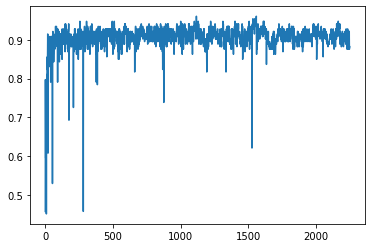

Epoch:  2251
Accuracy : 0.9150326797385621
Average prediction time 0.20381866731951315 31
Epoch:  2252
Accuracy : 0.9281045751633987
Average prediction time 0.20370737198860414 31
Epoch:  2253
Accuracy : 0.9215686274509803
Average prediction time 0.2037361821820659 31
Epoch:  2254
Accuracy : 0.9150326797385621
Average prediction time 0.2035721194359564 31
Epoch:  2255
Accuracy : 0.934640522875817
Average prediction time 0.20350582368912234 31
Epoch:  2256
Accuracy : 0.9019607843137255
Average prediction time 0.20339189806292135 31
Epoch:  2257
Accuracy : 0.9281045751633987
Average prediction time 0.20339347470191219 31
Epoch:  2258
Accuracy : 0.9281045751633987
Average prediction time 0.20344516538804577 31
Epoch:  2259
Accuracy : 0.9281045751633987
Average prediction time 0.2030811386723672 31
Epoch:  2260
Accuracy : 0.9150326797385621
Average prediction time 0.20393296210996567 31
Epoch:  2261
Accuracy : 0.9215686274509803
Average prediction time 0.2033908905521516 31
Epoch:  2262
Ac

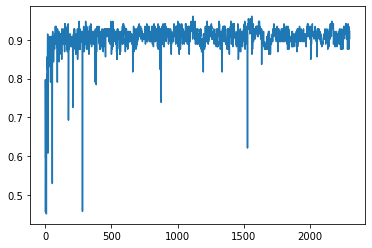

Epoch:  2301
Accuracy : 0.9215686274509803
Average prediction time 0.2034358439906951 31
Epoch:  2302
Accuracy : 0.9150326797385621
Average prediction time 0.20350127835427562 31
Epoch:  2303
Accuracy : 0.8758169934640523
Average prediction time 0.20348433525331558 31
Epoch:  2304
Accuracy : 0.8758169934640523
Average prediction time 0.20345141810755576 31
Epoch:  2305
Accuracy : 0.9019607843137255
Average prediction time 0.20328979338369063 31
Epoch:  2306
Accuracy : 0.9019607843137255
Average prediction time 0.20360899740649807 31
Epoch:  2307
Accuracy : 0.9019607843137255
Average prediction time 0.20337501648933656 31
Epoch:  2308
Accuracy : 0.9150326797385621
Average prediction time 0.20332634064459032 31
Epoch:  2309
Accuracy : 0.9150326797385621
Average prediction time 0.20318501995455834 31
Epoch:  2310
Accuracy : 0.9215686274509803
Average prediction time 0.20362615585327148 31
Epoch:  2311
Accuracy : 0.9215686274509803
Average prediction time 0.2034376129027336 31
Epoch:  2312

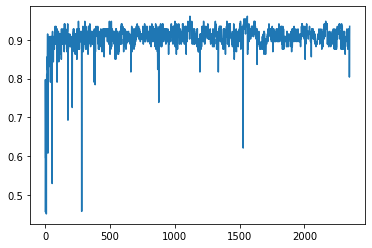

Epoch:  2351
Accuracy : 0.9281045751633987
Average prediction time 0.2033768238559846 31
Epoch:  2352
Accuracy : 0.9150326797385621
Average prediction time 0.2034092103281329 31
Epoch:  2353
Accuracy : 0.9084967320261438
Average prediction time 0.20326418261374196 31
Epoch:  2354
Accuracy : 0.934640522875817
Average prediction time 0.203706395241522 31
Epoch:  2355
Accuracy : 0.9281045751633987
Average prediction time 0.20342329240614368 31
Epoch:  2356
Accuracy : 0.934640522875817
Average prediction time 0.2034943872882474 31
Epoch:  2357
Accuracy : 0.9215686274509803
Average prediction time 0.2033052829004103 31
Epoch:  2358
Accuracy : 0.9084967320261438
Average prediction time 0.20370895631851688 31
Epoch:  2359
Accuracy : 0.9019607843137255
Average prediction time 0.20352275909916048 31
Epoch:  2360
Accuracy : 0.9019607843137255
Average prediction time 0.2037519254992085 31
Epoch:  2361
Accuracy : 0.9215686274509803
Average prediction time 0.20359409239984327 31
Epoch:  2362
Accura

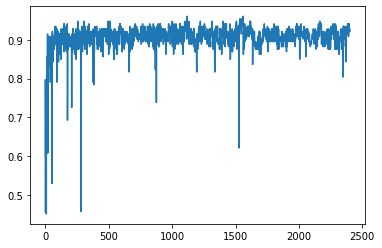

Epoch:  2401
Accuracy : 0.934640522875817
Average prediction time 0.20328916272809427 31
Epoch:  2402
Accuracy : 0.934640522875817
Average prediction time 0.2036021601769232 31
Epoch:  2403
Accuracy : 0.9215686274509803
Average prediction time 0.20356818937486218 31
Epoch:  2404
Accuracy : 0.9215686274509803
Average prediction time 0.20346788437135757 31
Epoch:  2405
Accuracy : 0.9150326797385621
Average prediction time 0.20337608552748157 31
Epoch:  2406
Accuracy : 0.9150326797385621
Average prediction time 0.20351691399851152 31
Epoch:  2407
Accuracy : 0.9150326797385621
Average prediction time 0.20349174161111155 31
Epoch:  2408
Accuracy : 0.9150326797385621
Average prediction time 0.2034157476117534 31
Epoch:  2409
Accuracy : 0.9215686274509803
Average prediction time 0.20316197026160457 31
Epoch:  2410
Accuracy : 0.9150326797385621
Average prediction time 0.20352412808325984 31
Epoch:  2411
Accuracy : 0.9150326797385621
Average prediction time 0.20357925661148563 31
Epoch:  2412
A

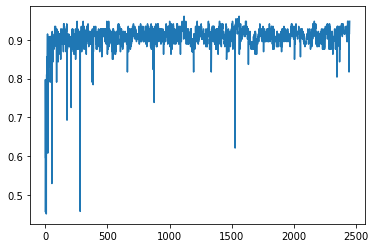

Epoch:  2451
Accuracy : 0.9411764705882353
Average prediction time 0.2037260378560712 31
Epoch:  2452
Accuracy : 0.9281045751633987
Average prediction time 0.2033823997743668 31
Epoch:  2453
Accuracy : 0.9281045751633987
Average prediction time 0.20336501829085812 31
Epoch:  2454
Accuracy : 0.9411764705882353
Average prediction time 0.2034960792910668 31
Epoch:  2455
Accuracy : 0.9281045751633987
Average prediction time 0.20342353851564468 31
Epoch:  2456
Accuracy : 0.9281045751633987
Average prediction time 0.20333999203097436 31
Epoch:  2457
Accuracy : 0.9150326797385621
Average prediction time 0.2036269941637593 31
Epoch:  2458
Accuracy : 0.934640522875817
Average prediction time 0.20362496376037598 31
Epoch:  2459
Accuracy : 0.9281045751633987
Average prediction time 0.20340684921510757 31
Epoch:  2460
Accuracy : 0.9411764705882353
Average prediction time 0.2032560686911306 31
Epoch:  2461
Accuracy : 0.934640522875817
Average prediction time 0.20337277843106177 31
Epoch:  2462
Accu

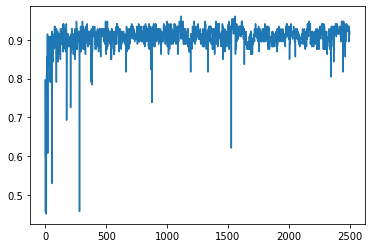

Epoch:  2501
Accuracy : 0.9215686274509803
Average prediction time 0.20338809105657762 31
Epoch:  2502
Accuracy : 0.9215686274509803
Average prediction time 0.2034283914873677 31
Epoch:  2503
Accuracy : 0.9281045751633987
Average prediction time 0.2037238767070155 31
Epoch:  2504
Accuracy : 0.9281045751633987
Average prediction time 0.20330141436669133 31
Epoch:  2505
Accuracy : 0.934640522875817
Average prediction time 0.20352506637573242 31
Epoch:  2506
Accuracy : 0.934640522875817
Average prediction time 0.20349244148500503 31
Epoch:  2507
Accuracy : 0.9411764705882353
Average prediction time 0.2032871477065548 31
Epoch:  2508
Accuracy : 0.9411764705882353
Average prediction time 0.20362009540680917 31
Epoch:  2509
Accuracy : 0.9411764705882353
Average prediction time 0.2039288628485895 31
Epoch:  2510
Accuracy : 0.934640522875817
Average prediction time 0.20366091882028886 31
Epoch:  2511
Accuracy : 0.934640522875817
Average prediction time 0.2035443167532644 31
Epoch:  2512
Accura

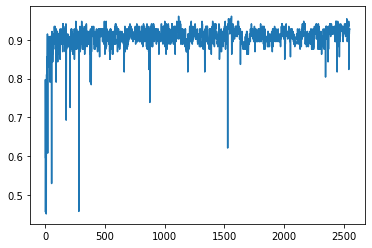

Epoch:  2551
Accuracy : 0.9281045751633987
Average prediction time 0.20393309285563807 31
Epoch:  2552
Accuracy : 0.9281045751633987
Average prediction time 0.20336767165891587 31
Epoch:  2553
Accuracy : 0.9281045751633987
Average prediction time 0.2039571500593616 31
Epoch:  2554
Accuracy : 0.934640522875817
Average prediction time 0.2033863913628363 31
Epoch:  2555
Accuracy : 0.9150326797385621
Average prediction time 0.20337674694676552 31
Epoch:  2556
Accuracy : 0.9215686274509803
Average prediction time 0.20354931585250363 31
Epoch:  2557
Accuracy : 0.9281045751633987
Average prediction time 0.20345179496272917 31
Epoch:  2558
Accuracy : 0.9281045751633987
Average prediction time 0.20331502729846584 31
Epoch:  2559
Accuracy : 0.9281045751633987
Average prediction time 0.20361126622846049 31
Epoch:  2560
Accuracy : 0.9477124183006536
Average prediction time 0.20366064194710023 31
Epoch:  2561
Accuracy : 0.9411764705882353
Average prediction time 0.20346916875531595 31
Epoch:  2562


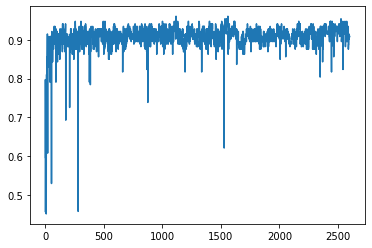

Epoch:  2601
Accuracy : 0.9084967320261438
Average prediction time 0.203497709766511 31
Epoch:  2602
Accuracy : 0.9019607843137255
Average prediction time 0.20316091660530336 31
Epoch:  2603
Accuracy : 0.9019607843137255
Average prediction time 0.203382961211666 31
Epoch:  2604
Accuracy : 0.9215686274509803
Average prediction time 0.20367617760935136 31
Epoch:  2605
Accuracy : 0.8954248366013072
Average prediction time 0.20348927282517956 31
Epoch:  2606
Accuracy : 0.8758169934640523
Average prediction time 0.20354612411991244 31
Epoch:  2607
Accuracy : 0.9215686274509803
Average prediction time 0.20325685316516506 31
Epoch:  2608
Accuracy : 0.9215686274509803
Average prediction time 0.20345720168082945 31
Epoch:  2609
Accuracy : 0.9019607843137255
Average prediction time 0.2034354978992093 31
Epoch:  2610
Accuracy : 0.8823529411764706
Average prediction time 0.20355232300296908 31
Epoch:  2611
Accuracy : 0.9150326797385621
Average prediction time 0.20347760569664738 31
Epoch:  2612
Ac

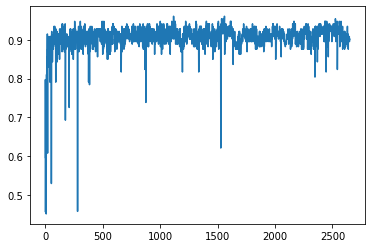

Epoch:  2651
Accuracy : 0.9150326797385621
Average prediction time 0.20358238681670157 31
Epoch:  2652
Accuracy : 0.9150326797385621
Average prediction time 0.20365060529401224 31
Epoch:  2653
Accuracy : 0.9150326797385621
Average prediction time 0.20330978978064754 31
Epoch:  2654
Accuracy : 0.9281045751633987
Average prediction time 0.20323756433302356 31
Epoch:  2655
Accuracy : 0.9281045751633987
Average prediction time 0.203366671839068 31
Epoch:  2656
Accuracy : 0.8758169934640523
Average prediction time 0.20337187090227682 31
Epoch:  2657
Accuracy : 0.9150326797385621
Average prediction time 0.20350589290741952 31
Epoch:  2658
Accuracy : 0.9084967320261438
Average prediction time 0.20340365748251638 31
Epoch:  2659
Accuracy : 0.9084967320261438
Average prediction time 0.20393670758893412 31
Epoch:  2660
Accuracy : 0.9019607843137255
Average prediction time 0.20359613049414851 31
Epoch:  2661
Accuracy : 0.8888888888888888
Average prediction time 0.20325046969998267 31
Epoch:  2662

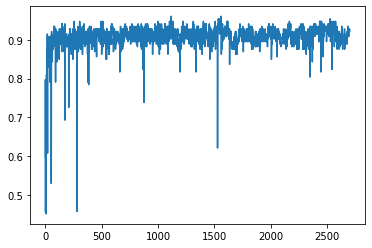

Epoch:  2701
Accuracy : 0.9281045751633987
Average prediction time 0.2035699736687445 31
Epoch:  2702
Accuracy : 0.9281045751633987
Average prediction time 0.20344624980803458 31
Epoch:  2703
Accuracy : 0.9281045751633987
Average prediction time 0.20335524312911496 31
Epoch:  2704
Accuracy : 0.9281045751633987
Average prediction time 0.2037235306155297 31
Epoch:  2705
Accuracy : 0.9281045751633987
Average prediction time 0.20383108815839213 31
Epoch:  2706
Accuracy : 0.9281045751633987
Average prediction time 0.20354067125628073 31
Epoch:  2707
Accuracy : 0.9150326797385621
Average prediction time 0.2035804102497716 31
Epoch:  2708
Accuracy : 0.9150326797385621
Average prediction time 0.2033728168856713 31
Epoch:  2709
Accuracy : 0.9150326797385621
Average prediction time 0.20328923194639145 31
Epoch:  2710
Accuracy : 0.9150326797385621
Average prediction time 0.20331505037123157 31
Epoch:  2711
Accuracy : 0.9150326797385621
Average prediction time 0.20353240351523122 31
Epoch:  2712
A

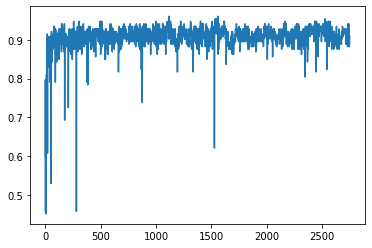

Epoch:  2751
Accuracy : 0.9215686274509803
Average prediction time 0.20337713149286085 31
Epoch:  2752
Accuracy : 0.9084967320261438
Average prediction time 0.20368230727411085 31
Epoch:  2753
Accuracy : 0.9150326797385621
Average prediction time 0.20400865616336947 31
Epoch:  2754
Accuracy : 0.9084967320261438
Average prediction time 0.20366977876232517 31
Epoch:  2755
Accuracy : 0.9084967320261438
Average prediction time 0.20336700254870999 31
Epoch:  2756
Accuracy : 0.9281045751633987
Average prediction time 0.20386468210527975 31
Epoch:  2757
Accuracy : 0.9281045751633987
Average prediction time 0.2037834967336347 31
Epoch:  2758
Accuracy : 0.9281045751633987
Average prediction time 0.20363970725767075 31
Epoch:  2759
Accuracy : 0.9281045751633987
Average prediction time 0.20346710758824502 31
Epoch:  2760
Accuracy : 0.9281045751633987
Average prediction time 0.20351454519456433 31
Epoch:  2761
Accuracy : 0.9215686274509803
Average prediction time 0.20339832767363517 31
Epoch:  276

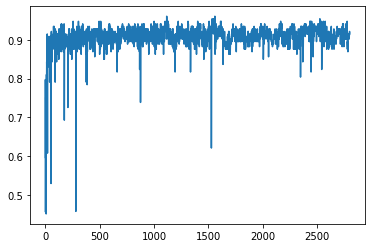

Epoch:  2801
Accuracy : 0.8888888888888888
Average prediction time 0.20337204010255874 31
Epoch:  2802
Accuracy : 0.9084967320261438
Average prediction time 0.2033506901033463 31
Epoch:  2803
Accuracy : 0.9019607843137255
Average prediction time 0.2034580938277706 31
Epoch:  2804
Accuracy : 0.9019607843137255
Average prediction time 0.20346299294502504 31
Epoch:  2805
Accuracy : 0.9215686274509803
Average prediction time 0.2033981200187437 31
Epoch:  2806
Accuracy : 0.9150326797385621
Average prediction time 0.20372626089280652 31
Epoch:  2807
Accuracy : 0.9150326797385621
Average prediction time 0.20334003048558388 31
Epoch:  2808
Accuracy : 0.9150326797385621
Average prediction time 0.20342775314084946 31
Epoch:  2809
Accuracy : 0.9150326797385621
Average prediction time 0.2037503642420615 31
Epoch:  2810
Accuracy : 0.9084967320261438
Average prediction time 0.20348853449667653 31
Epoch:  2811
Accuracy : 0.9150326797385621
Average prediction time 0.2035239742648217 31
Epoch:  2812
Ac

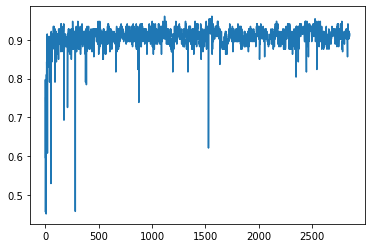

Epoch:  2851
Accuracy : 0.9019607843137255
Average prediction time 0.20358258678067115 31
Epoch:  2852
Accuracy : 0.9477124183006536
Average prediction time 0.2036217951005505 31
Epoch:  2853
Accuracy : 0.934640522875817
Average prediction time 0.2035156988328503 31
Epoch:  2854
Accuracy : 0.8823529411764706
Average prediction time 0.2033991813659668 31
Epoch:  2855
Accuracy : 0.934640522875817
Average prediction time 0.2035041932136782 31
Epoch:  2856
Accuracy : 0.9215686274509803
Average prediction time 0.2039322929997598 31
Epoch:  2857
Accuracy : 0.9150326797385621
Average prediction time 0.20356735875529627 31
Epoch:  2858
Accuracy : 0.8888888888888888
Average prediction time 0.20329446177328786 31
Epoch:  2859
Accuracy : 0.8954248366013072
Average prediction time 0.20350740801903508 31
Epoch:  2860
Accuracy : 0.9019607843137255
Average prediction time 0.20353220355126164 31
Epoch:  2861
Accuracy : 0.9019607843137255
Average prediction time 0.203355073928833 31
Epoch:  2862
Accura

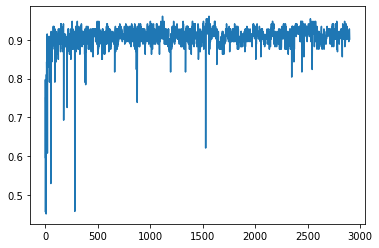

Epoch:  2901
Accuracy : 0.9215686274509803
Average prediction time 0.20335481243748818 31
Epoch:  2902
Accuracy : 0.9019607843137255
Average prediction time 0.20326602074407762 31
Epoch:  2903
Accuracy : 0.9019607843137255
Average prediction time 0.20348690402123235 31
Epoch:  2904
Accuracy : 0.9150326797385621
Average prediction time 0.20363401597545994 31
Epoch:  2905
Accuracy : 0.9215686274509803
Average prediction time 0.20329749968744093 31
Epoch:  2906
Accuracy : 0.934640522875817
Average prediction time 0.20331348142316263 31
Epoch:  2907
Accuracy : 0.934640522875817
Average prediction time 0.203628416984312 31
Epoch:  2908
Accuracy : 0.9281045751633987
Average prediction time 0.20359536140195786 31
Epoch:  2909
Accuracy : 0.9215686274509803
Average prediction time 0.20370477245699975 31
Epoch:  2910
Accuracy : 0.9281045751633987
Average prediction time 0.20340264228082472 31
Epoch:  2911
Accuracy : 0.9215686274509803
Average prediction time 0.20348794229568973 31
Epoch:  2912
A

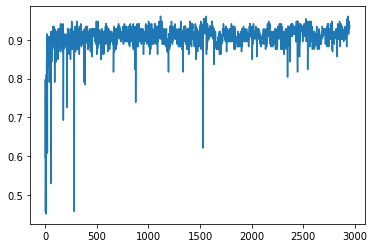

Epoch:  2951
Accuracy : 0.934640522875817
Average prediction time 0.20365106674932665 31
Epoch:  2952
Accuracy : 0.9477124183006536
Average prediction time 0.20347791333352366 31
Epoch:  2953
Accuracy : 0.9411764705882353
Average prediction time 0.20352458953857422 31
Epoch:  2954
Accuracy : 0.934640522875817
Average prediction time 0.203554714879682 31
Epoch:  2955
Accuracy : 0.9411764705882353
Average prediction time 0.20346239305311634 31
Epoch:  2956
Accuracy : 0.9477124183006536
Average prediction time 0.20358600154999765 31
Epoch:  2957
Accuracy : 0.954248366013072
Average prediction time 0.20352840423583984 31
Epoch:  2958
Accuracy : 0.9673202614379085
Average prediction time 0.2035020859010758 31
Epoch:  2959
Accuracy : 0.9607843137254902
Average prediction time 0.2034905033726846 31
Epoch:  2960
Accuracy : 0.954248366013072
Average prediction time 0.2034246152447116 31
Epoch:  2961
Accuracy : 0.9281045751633987
Average prediction time 0.20333055526979507 31
Epoch:  2962
Accura

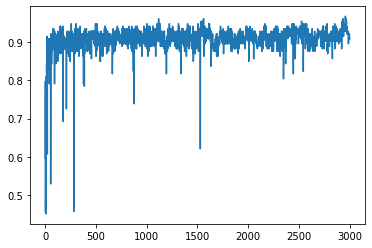

Epoch:  3001
Accuracy : 0.9084967320261438
Average prediction time 0.2036022986135175 31
Epoch:  3002
Accuracy : 0.9084967320261438
Average prediction time 0.20349151088345435 31
Epoch:  3003
Accuracy : 0.9084967320261438
Average prediction time 0.20354448595354635 31
Epoch:  3004
Accuracy : 0.9281045751633987
Average prediction time 0.20369903502925749 31
Epoch:  3005
Accuracy : 0.9281045751633987
Average prediction time 0.2037458727436681 31
Epoch:  3006
Accuracy : 0.9215686274509803
Average prediction time 0.20339035987854004 31
Epoch:  3007
Accuracy : 0.9281045751633987
Average prediction time 0.20367540851716073 31
Epoch:  3008
Accuracy : 0.9084967320261438
Average prediction time 0.20340777981665828 31
Epoch:  3009
Accuracy : 0.9215686274509803
Average prediction time 0.2036345543399934 31
Epoch:  3010
Accuracy : 0.9150326797385621
Average prediction time 0.20357039666944934 31
Epoch:  3011
Accuracy : 0.9215686274509803
Average prediction time 0.20342340776997228 31
Epoch:  3012


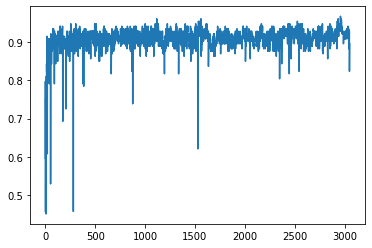

Epoch:  3051
Accuracy : 0.9215686274509803
Average prediction time 0.20345095665224136 31
Epoch:  3052
Accuracy : 0.9150326797385621
Average prediction time 0.20336509520007717 31
Epoch:  3053
Accuracy : 0.9084967320261438
Average prediction time 0.20337270921276462 31
Epoch:  3054
Accuracy : 0.9084967320261438
Average prediction time 0.20369592020588537 31
Epoch:  3055
Accuracy : 0.9084967320261438
Average prediction time 0.20360318306953676 31
Epoch:  3056
Accuracy : 0.9150326797385621
Average prediction time 0.20336767934983777 31
Epoch:  3057
Accuracy : 0.9019607843137255
Average prediction time 0.20345747855401808 31
Epoch:  3058
Accuracy : 0.9150326797385621
Average prediction time 0.20334082265054026 31
Epoch:  3059
Accuracy : 0.8823529411764706
Average prediction time 0.20328341760943014 31
Epoch:  3060
Accuracy : 0.8823529411764706
Average prediction time 0.20401886970766128 31
Epoch:  3061
Accuracy : 0.9215686274509803
Average prediction time 0.2033344776399674 31
Epoch:  306

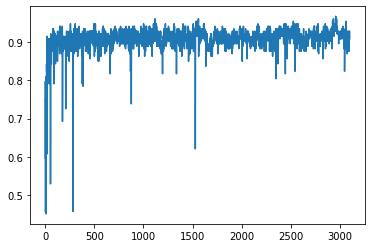

Epoch:  3101
Accuracy : 0.9019607843137255
Average prediction time 0.2036520819510183 31
Epoch:  3102
Accuracy : 0.9084967320261438
Average prediction time 0.20342552277349657 31
Epoch:  3103
Accuracy : 0.9084967320261438
Average prediction time 0.20352899643682665 31
Epoch:  3104
Accuracy : 0.9281045751633987
Average prediction time 0.20333349320196337 31
Epoch:  3105
Accuracy : 0.9281045751633987
Average prediction time 0.2033905444606658 31
Epoch:  3106
Accuracy : 0.9281045751633987
Average prediction time 0.20344594986208023 31
Epoch:  3107
Accuracy : 0.869281045751634
Average prediction time 0.20326416723189816 31
Epoch:  3108
Accuracy : 0.9084967320261438
Average prediction time 0.20359031615718717 31
Epoch:  3109
Accuracy : 0.9019607843137255
Average prediction time 0.20347876702585527 31
Epoch:  3110
Accuracy : 0.8823529411764706
Average prediction time 0.20368273796573763 31
Epoch:  3111
Accuracy : 0.8954248366013072
Average prediction time 0.20373393643286922 31
Epoch:  3112


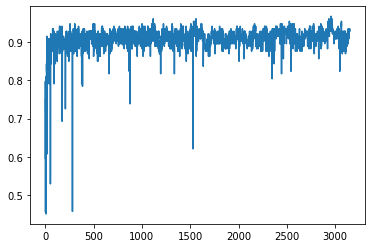

Epoch:  3151
Accuracy : 0.934640522875817
Average prediction time 0.20340055804098806 31
Epoch:  3152
Accuracy : 0.9019607843137255
Average prediction time 0.20327739561757735 31
Epoch:  3153
Accuracy : 0.9150326797385621
Average prediction time 0.20337224775745022 31
Epoch:  3154
Accuracy : 0.9084967320261438
Average prediction time 0.20361496556189754 31
Epoch:  3155
Accuracy : 0.8888888888888888
Average prediction time 0.2033330625103366 31
Epoch:  3156
Accuracy : 0.9281045751633987
Average prediction time 0.20368365318544449 31
Epoch:  3157
Accuracy : 0.934640522875817
Average prediction time 0.20336212650422128 31
Epoch:  3158
Accuracy : 0.9215686274509803
Average prediction time 0.20356907383088144 31
Epoch:  3159
Accuracy : 0.8562091503267973
Average prediction time 0.20342223105892057 31
Epoch:  3160
Accuracy : 0.9281045751633987
Average prediction time 0.20345412531206686 31
Epoch:  3161
Accuracy : 0.9019607843137255
Average prediction time 0.20347399096335134 31
Epoch:  3162


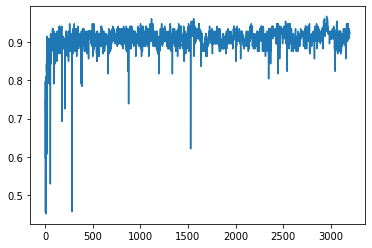

Epoch:  3201
Accuracy : 0.9084967320261438
Average prediction time 0.2035555685720136 31
Epoch:  3202
Accuracy : 0.9411764705882353
Average prediction time 0.2035472546854327 31
Epoch:  3203
Accuracy : 0.9411764705882353
Average prediction time 0.2034509720340852 31
Epoch:  3204
Accuracy : 0.9281045751633987
Average prediction time 0.20337936186021374 31
Epoch:  3205
Accuracy : 0.9281045751633987
Average prediction time 0.2031904266726586 31
Epoch:  3206
Accuracy : 0.9281045751633987
Average prediction time 0.20347993604598508 31
Epoch:  3207
Accuracy : 0.9215686274509803
Average prediction time 0.20326258290198543 31
Epoch:  3208
Accuracy : 0.9281045751633987
Average prediction time 0.20334768295288086 31
Epoch:  3209
Accuracy : 0.9411764705882353
Average prediction time 0.20320076327170095 31
Epoch:  3210
Accuracy : 0.9281045751633987
Average prediction time 0.20372786829548498 31
Epoch:  3211
Accuracy : 0.9281045751633987
Average prediction time 0.2032700046416252 31
Epoch:  3212
Ac

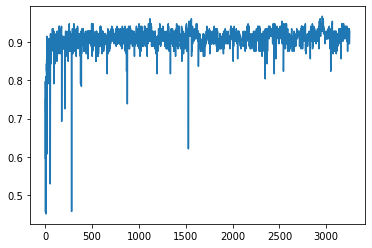

Epoch:  3251
Accuracy : 0.9150326797385621
Average prediction time 0.20383493361934538 31
Epoch:  3252
Accuracy : 0.9150326797385621
Average prediction time 0.20369685849835795 31
Epoch:  3253
Accuracy : 0.8954248366013072
Average prediction time 0.20377316782551427 31
Epoch:  3254
Accuracy : 0.9281045751633987
Average prediction time 0.20359894537156628 31
Epoch:  3255
Accuracy : 0.9215686274509803
Average prediction time 0.20332534082474246 31
Epoch:  3256
Accuracy : 0.9281045751633987
Average prediction time 0.2034211697116975 31
Epoch:  3257
Accuracy : 0.934640522875817
Average prediction time 0.20372660698429232 31
Epoch:  3258
Accuracy : 0.934640522875817
Average prediction time 0.20345164883521297 31
Epoch:  3259
Accuracy : 0.9150326797385621
Average prediction time 0.20337442428834976 31
Epoch:  3260
Accuracy : 0.9411764705882353
Average prediction time 0.20358668604204733 31
Epoch:  3261
Accuracy : 0.934640522875817
Average prediction time 0.20352429728354177 31
Epoch:  3262
A

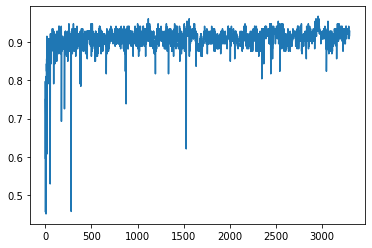

Epoch:  3301
Accuracy : 0.9281045751633987
Average prediction time 0.203669217325026 31
Epoch:  3302
Accuracy : 0.934640522875817
Average prediction time 0.20347043775743054 31
Epoch:  3303
Accuracy : 0.934640522875817
Average prediction time 0.20359513067430066 31
Epoch:  3304
Accuracy : 0.9411764705882353
Average prediction time 0.20339699714414536 31
Epoch:  3305
Accuracy : 0.9281045751633987
Average prediction time 0.20341438631857595 31
Epoch:  3306
Accuracy : 0.9281045751633987
Average prediction time 0.20346999937488186 31
Epoch:  3307
Accuracy : 0.9281045751633987
Average prediction time 0.20358777815295803 31
Epoch:  3308
Accuracy : 0.9019607843137255
Average prediction time 0.2034116098957677 31
Epoch:  3309
Accuracy : 0.9019607843137255
Average prediction time 0.20355895257765247 31
Epoch:  3310
Accuracy : 0.9150326797385621
Average prediction time 0.20397010926277406 31
Epoch:  3311
Accuracy : 0.9019607843137255
Average prediction time 0.20385911387781944 31
Epoch:  3312
Ac

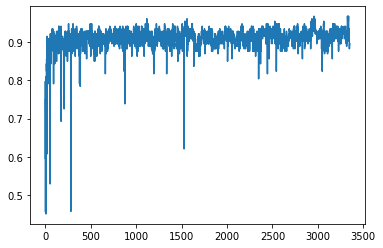

Epoch:  3351
Accuracy : 0.8954248366013072
Average prediction time 0.20337735452959615 31
Epoch:  3352
Accuracy : 0.9281045751633987
Average prediction time 0.20318755795878748 31
Epoch:  3353
Accuracy : 0.9215686274509803
Average prediction time 0.20355080020043156 31
Epoch:  3354
Accuracy : 0.9150326797385621
Average prediction time 0.20329894558075937 31
Epoch:  3355
Accuracy : 0.9281045751633987
Average prediction time 0.2038872318883096 31
Epoch:  3356
Accuracy : 0.9281045751633987
Average prediction time 0.2035213593513735 31
Epoch:  3357
Accuracy : 0.9281045751633987
Average prediction time 0.2034339520239061 31
Epoch:  3358
Accuracy : 0.9281045751633987
Average prediction time 0.20325780683948147 31
Epoch:  3359
Accuracy : 0.9281045751633987
Average prediction time 0.20341687048635176 31
Epoch:  3360
Accuracy : 0.9281045751633987
Average prediction time 0.20346088563242265 31
Epoch:  3361
Accuracy : 0.9281045751633987
Average prediction time 0.20338940620422363 31
Epoch:  3362


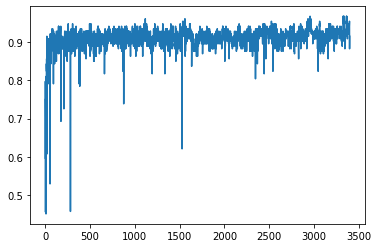

Epoch:  3401
Accuracy : 0.9150326797385621
Average prediction time 0.20362466381442162 31
Epoch:  3402
Accuracy : 0.9281045751633987
Average prediction time 0.2032891781099381 31
Epoch:  3403
Accuracy : 0.9215686274509803
Average prediction time 0.20350975375021657 31
Epoch:  3404
Accuracy : 0.9281045751633987
Average prediction time 0.20389643792183168 31
Epoch:  3405
Accuracy : 0.9215686274509803
Average prediction time 0.20341541690211143 31
Epoch:  3406
Accuracy : 0.9150326797385621
Average prediction time 0.20333536209598665 31
Epoch:  3407
Accuracy : 0.9215686274509803
Average prediction time 0.2033726861399989 31
Epoch:  3408
Accuracy : 0.9215686274509803
Average prediction time 0.20351919051139586 31
Epoch:  3409
Accuracy : 0.9281045751633987
Average prediction time 0.20342458448102396 31
Epoch:  3410
Accuracy : 0.9281045751633987
Average prediction time 0.2033270174457181 31
Epoch:  3411
Accuracy : 0.9281045751633987
Average prediction time 0.20334778293486563 31
Epoch:  3412


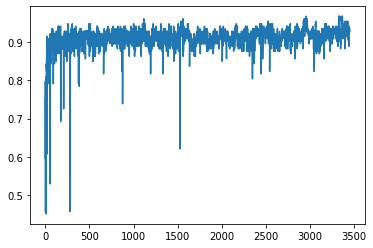

Epoch:  3451
Accuracy : 0.934640522875817
Average prediction time 0.20339979663971933 31
Epoch:  3452
Accuracy : 0.934640522875817
Average prediction time 0.20333998434005246 31
Epoch:  3453
Accuracy : 0.934640522875817
Average prediction time 0.20333798470035677 31
Epoch:  3454
Accuracy : 0.934640522875817
Average prediction time 0.20368143819993542 31
Epoch:  3455
Accuracy : 0.9477124183006536
Average prediction time 0.20337980024276242 31
Epoch:  3456
Accuracy : 0.9477124183006536
Average prediction time 0.20334694462437783 31
Epoch:  3457
Accuracy : 0.9477124183006536
Average prediction time 0.20342003145525533 31
Epoch:  3458
Accuracy : 0.934640522875817
Average prediction time 0.2034529947465466 31
Epoch:  3459
Accuracy : 0.9215686274509803
Average prediction time 0.20319223403930664 31
Epoch:  3460
Accuracy : 0.9411764705882353
Average prediction time 0.2032973535599247 31
Epoch:  3461
Accuracy : 0.9411764705882353
Average prediction time 0.20324241730474657 31
Epoch:  3462
Accu

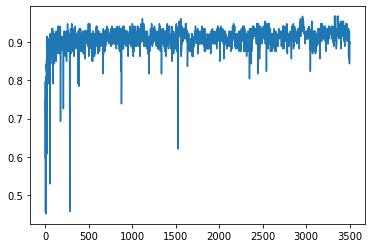

Epoch:  3501
Accuracy : 0.9084967320261438
Average prediction time 0.2035237589190083 31
Epoch:  3502
Accuracy : 0.9084967320261438
Average prediction time 0.20321820628258488 31
Epoch:  3503
Accuracy : 0.8758169934640523
Average prediction time 0.20333908450218938 31
Epoch:  3504
Accuracy : 0.8888888888888888
Average prediction time 0.20393675373446557 31
Epoch:  3505
Accuracy : 0.8954248366013072
Average prediction time 0.20346919182808168 31
Epoch:  3506
Accuracy : 0.8954248366013072
Average prediction time 0.20353927919941564 31
Epoch:  3507
Accuracy : 0.9019607843137255
Average prediction time 0.2035770646987423 31
Epoch:  3508
Accuracy : 0.9150326797385621
Average prediction time 0.20329716897779895 31
Epoch:  3509
Accuracy : 0.8954248366013072
Average prediction time 0.2033531742711221 31
Epoch:  3510
Accuracy : 0.9019607843137255
Average prediction time 0.20316536964908724 31
Epoch:  3511
Accuracy : 0.9084967320261438
Average prediction time 0.20327609585177514 31
Epoch:  3512


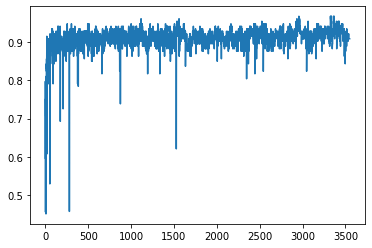

Epoch:  3551
Accuracy : 0.9084967320261438
Average prediction time 0.20360030666474374 31
Epoch:  3552
Accuracy : 0.9084967320261438
Average prediction time 0.20349331055918046 31
Epoch:  3553
Accuracy : 0.9084967320261438
Average prediction time 0.20369189016280637 31
Epoch:  3554
Accuracy : 0.9084967320261438
Average prediction time 0.2035569837016444 31
Epoch:  3555
Accuracy : 0.9150326797385621
Average prediction time 0.20331217396643855 31
Epoch:  3556
Accuracy : 0.9084967320261438
Average prediction time 0.2038724499364053 31
Epoch:  3557
Accuracy : 0.9215686274509803
Average prediction time 0.20368052298022854 31
Epoch:  3558
Accuracy : 0.9019607843137255
Average prediction time 0.20374684179982833 31
Epoch:  3559
Accuracy : 0.9084967320261438
Average prediction time 0.20362314101188414 31
Epoch:  3560
Accuracy : 0.9084967320261438
Average prediction time 0.203487673113423 31
Epoch:  3561
Accuracy : 0.9084967320261438
Average prediction time 0.20346782284398232 31
Epoch:  3562
A

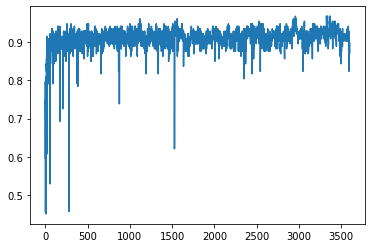

Epoch:  3601
Accuracy : 0.9019607843137255
Average prediction time 0.2035545918249315 31
Epoch:  3602
Accuracy : 0.9019607843137255
Average prediction time 0.2035085770391649 31
Epoch:  3603
Accuracy : 0.9019607843137255
Average prediction time 0.20320598540767545 31
Epoch:  3604
Accuracy : 0.9084967320261438
Average prediction time 0.20333621578831826 31
Epoch:  3605
Accuracy : 0.9084967320261438
Average prediction time 0.2034483955752465 31
Epoch:  3606
Accuracy : 0.9281045751633987
Average prediction time 0.2035348799920851 31
Epoch:  3607
Accuracy : 0.9215686274509803
Average prediction time 0.20360659783886326 31
Epoch:  3608
Accuracy : 0.9281045751633987
Average prediction time 0.20364172997013216 31
Epoch:  3609
Accuracy : 0.9215686274509803
Average prediction time 0.2034000119855327 31
Epoch:  3610
Accuracy : 0.9281045751633987
Average prediction time 0.20343658231919812 31
Epoch:  3611
Accuracy : 0.9281045751633987
Average prediction time 0.20335077470348728 31
Epoch:  3612
Ac

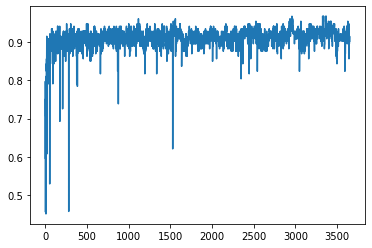

Epoch:  3651
Accuracy : 0.9411764705882353
Average prediction time 0.20342810692325716 31
Epoch:  3652
Accuracy : 0.9411764705882353
Average prediction time 0.2036349311951668 31
Epoch:  3653
Accuracy : 0.9411764705882353
Average prediction time 0.20345615571545017 31
Epoch:  3654
Accuracy : 0.934640522875817
Average prediction time 0.20345787848195723 31
Epoch:  3655
Accuracy : 0.934640522875817
Average prediction time 0.20350494692402502 31
Epoch:  3656
Accuracy : 0.9281045751633987
Average prediction time 0.20324879307900706 31
Epoch:  3657
Accuracy : 0.9281045751633987
Average prediction time 0.20349171084742393 31
Epoch:  3658
Accuracy : 0.9281045751633987
Average prediction time 0.20338138457267516 31
Epoch:  3659
Accuracy : 0.8954248366013072
Average prediction time 0.20337998482488817 31
Epoch:  3660
Accuracy : 0.9215686274509803
Average prediction time 0.20339249795483005 31
Epoch:  3661
Accuracy : 0.9215686274509803
Average prediction time 0.2034565633343112 31
Epoch:  3662
A

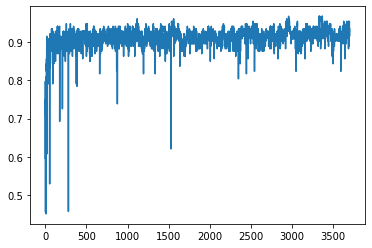

Epoch:  3701
Accuracy : 0.934640522875817
Average prediction time 0.2038264197687949 31
Epoch:  3702
Accuracy : 0.9281045751633987
Average prediction time 0.2034640081467167 31
Epoch:  3703
Accuracy : 0.9281045751633987
Average prediction time 0.20350142448179184 31
Epoch:  3704
Accuracy : 0.9281045751633987
Average prediction time 0.2032907393670851 31
Epoch:  3705
Accuracy : 0.9281045751633987
Average prediction time 0.20343705915635632 31
Epoch:  3706
Accuracy : 0.9411764705882353
Average prediction time 0.2033416994156376 31
Epoch:  3707
Accuracy : 0.9411764705882353
Average prediction time 0.20350648510840633 31
Epoch:  3708
Accuracy : 0.9477124183006536
Average prediction time 0.20353054231212986 31
Epoch:  3709
Accuracy : 0.954248366013072
Average prediction time 0.20327058146076818 31
Epoch:  3710
Accuracy : 0.934640522875817
Average prediction time 0.2035456395918323 31
Epoch:  3711
Accuracy : 0.934640522875817
Average prediction time 0.20358683216956355 31
Epoch:  3712
Accura

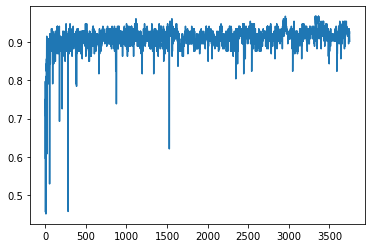

Epoch:  3751
Accuracy : 0.9019607843137255
Average prediction time 0.20347385252675704 31
Epoch:  3752
Accuracy : 0.9019607843137255
Average prediction time 0.20333125514368858 31
Epoch:  3753
Accuracy : 0.9084967320261438
Average prediction time 0.20334981333824895 31
Epoch:  3754
Accuracy : 0.9150326797385621
Average prediction time 0.20342050829241354 31
Epoch:  3755
Accuracy : 0.9215686274509803
Average prediction time 0.20352815812633884 31
Epoch:  3756
Accuracy : 0.9150326797385621
Average prediction time 0.2033409918508222 31
Epoch:  3757
Accuracy : 0.9150326797385621
Average prediction time 0.2032767495801372 31
Epoch:  3758
Accuracy : 0.934640522875817
Average prediction time 0.2034508797430223 31
Epoch:  3759
Accuracy : 0.9215686274509803
Average prediction time 0.2038332954529793 31
Epoch:  3760
Accuracy : 0.9019607843137255
Average prediction time 0.20336114206621725 31
Epoch:  3761
Accuracy : 0.954248366013072
Average prediction time 0.20366607173796622 31
Epoch:  3762
Acc

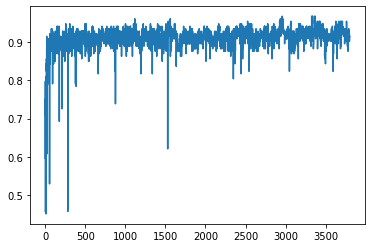

Epoch:  3801
Accuracy : 0.9150326797385621
Average prediction time 0.2038530457404352 31
Epoch:  3802
Accuracy : 0.9019607843137255
Average prediction time 0.2035463394657258 31
Epoch:  3803
Accuracy : 0.9084967320261438
Average prediction time 0.20362516372434555 31
Epoch:  3804
Accuracy : 0.8888888888888888
Average prediction time 0.20393078557906613 31
Epoch:  3805
Accuracy : 0.8954248366013072
Average prediction time 0.20353289573423325 31
Epoch:  3806
Accuracy : 0.8954248366013072
Average prediction time 0.20361960318780714 31
Epoch:  3807
Accuracy : 0.9084967320261438
Average prediction time 0.2035427554961174 31
Epoch:  3808
Accuracy : 0.8954248366013072
Average prediction time 0.2034475495738368 31
Epoch:  3809
Accuracy : 0.8954248366013072
Average prediction time 0.20362893996700163 31
Epoch:  3810
Accuracy : 0.8954248366013072
Average prediction time 0.20370257285333448 31
Epoch:  3811
Accuracy : 0.9019607843137255
Average prediction time 0.20343000658096805 31
Epoch:  3812
A

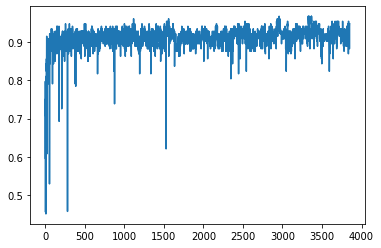

Epoch:  3851
Accuracy : 0.9477124183006536
Average prediction time 0.20338920624025406 31
Epoch:  3852
Accuracy : 0.9477124183006536
Average prediction time 0.203540648183515 31
Epoch:  3853
Accuracy : 0.9477124183006536
Average prediction time 0.2034356440267255 31
Epoch:  3854
Accuracy : 0.9411764705882353
Average prediction time 0.2034464959175356 31
Epoch:  3855
Accuracy : 0.9477124183006536
Average prediction time 0.2037325059213946 31
Epoch:  3856
Accuracy : 0.934640522875817
Average prediction time 0.20350746185548843 31
Epoch:  3857
Accuracy : 0.934640522875817
Average prediction time 0.20330069142003213 31
Epoch:  3858
Accuracy : 0.9477124183006536
Average prediction time 0.20353801788822298 31
Epoch:  3859
Accuracy : 0.9411764705882353
Average prediction time 0.20329907632643177 31
Epoch:  3860
Accuracy : 0.9411764705882353
Average prediction time 0.20349934024195518 31
Epoch:  3861
Accuracy : 0.9281045751633987
Average prediction time 0.2032146761494298 31
Epoch:  3862
Accur

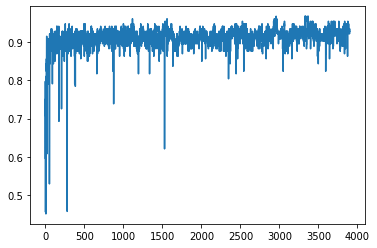

Epoch:  3901
Accuracy : 0.9084967320261438
Average prediction time 0.20342796079574094 31
Epoch:  3902
Accuracy : 0.9215686274509803
Average prediction time 0.20321989059448242 31
Epoch:  3903
Accuracy : 0.9215686274509803
Average prediction time 0.20354758539507467 31
Epoch:  3904
Accuracy : 0.9281045751633987
Average prediction time 0.2035454011732532 31
Epoch:  3905
Accuracy : 0.9215686274509803
Average prediction time 0.2034961869639735 31
Epoch:  3906
Accuracy : 0.954248366013072
Average prediction time 0.20331540415363927 31
Epoch:  3907
Accuracy : 0.9019607843137255
Average prediction time 0.20350139371810422 31
Epoch:  3908
Accuracy : 0.9411764705882353
Average prediction time 0.2032686971849011 31
Epoch:  3909
Accuracy : 0.9477124183006536
Average prediction time 0.20339498981352774 31
Epoch:  3910
Accuracy : 0.9477124183006536
Average prediction time 0.20359405394523375 31
Epoch:  3911
Accuracy : 0.9281045751633987
Average prediction time 0.2035163833249 31
Epoch:  3912
Accur

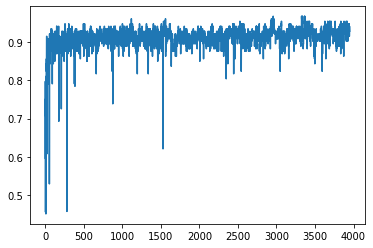

Epoch:  3951
Accuracy : 0.9477124183006536
Average prediction time 0.2033363772976783 31
Epoch:  3952
Accuracy : 0.9215686274509803
Average prediction time 0.20332501011510049 31
Epoch:  3953
Accuracy : 0.934640522875817
Average prediction time 0.20350567756160612 31
Epoch:  3954
Accuracy : 0.934640522875817
Average prediction time 0.20336569509198588 31
Epoch:  3955
Accuracy : 0.9477124183006536
Average prediction time 0.20352116707832582 31
Epoch:  3956
Accuracy : 0.9411764705882353
Average prediction time 0.20340693381524855 31
Epoch:  3957
Accuracy : 0.9411764705882353
Average prediction time 0.20332863253931846 31
Epoch:  3958
Accuracy : 0.9411764705882353
Average prediction time 0.20356079839891003 31
Epoch:  3959
Accuracy : 0.9411764705882353
Average prediction time 0.2033884371480634 31
Epoch:  3960
Accuracy : 0.9477124183006536
Average prediction time 0.20359180050511513 31
Epoch:  3961
Accuracy : 0.9477124183006536
Average prediction time 0.20343932028739684 31
Epoch:  3962
A

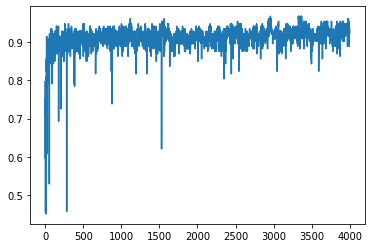

Epoch:  4001
Accuracy : 0.934640522875817
Average prediction time 0.20356061381678428 31
Epoch:  4002
Accuracy : 0.9084967320261438
Average prediction time 0.20349947098762758 31
Epoch:  4003
Accuracy : 0.9215686274509803
Average prediction time 0.203589508610387 31
Epoch:  4004
Accuracy : 0.9150326797385621
Average prediction time 0.20330922065242643 31
Epoch:  4005
Accuracy : 0.9150326797385621
Average prediction time 0.20358374810987903 31
Epoch:  4006
Accuracy : 0.9281045751633987
Average prediction time 0.20341494775587513 31
Epoch:  4007
Accuracy : 0.954248366013072
Average prediction time 0.2034129173524918 31
Epoch:  4008
Accuracy : 0.954248366013072
Average prediction time 0.2038689044214064 31
Epoch:  4009
Accuracy : 0.9477124183006536
Average prediction time 0.20344498080592002 31
Epoch:  4010
Accuracy : 0.9019607843137255
Average prediction time 0.20340688766971712 31
Epoch:  4011
Accuracy : 0.9150326797385621
Average prediction time 0.20389666864948888 31
Epoch:  4012
Accu

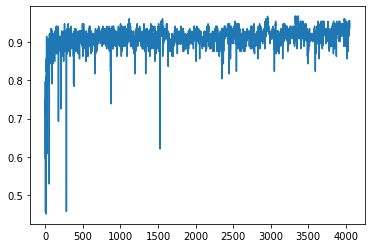

Epoch:  4051
Accuracy : 0.9607843137254902
Average prediction time 0.20353081149439659 31
Epoch:  4052
Accuracy : 0.9607843137254902
Average prediction time 0.20358903946415072 31
Epoch:  4053
Accuracy : 0.9607843137254902
Average prediction time 0.20374625728976342 31
Epoch:  4054
Accuracy : 0.9607843137254902
Average prediction time 0.20368528366088867 31
Epoch:  4055
Accuracy : 0.9607843137254902
Average prediction time 0.20350820787491336 31
Epoch:  4056
Accuracy : 0.954248366013072
Average prediction time 0.20350743878272273 31
Epoch:  4057
Accuracy : 0.9607843137254902
Average prediction time 0.2032451937275548 31
Epoch:  4058
Accuracy : 0.9673202614379085
Average prediction time 0.20377785159695533 31
Epoch:  4059
Accuracy : 0.9607843137254902
Average prediction time 0.2034855273462111 31
Epoch:  4060
Accuracy : 0.9607843137254902
Average prediction time 0.2034430811482091 31
Epoch:  4061
Accuracy : 0.9477124183006536
Average prediction time 0.20347716731409873 31
Epoch:  4062
A

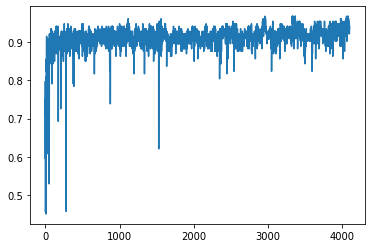

Epoch:  4101
Accuracy : 0.9411764705882353
Average prediction time 0.20349857884068642 31
Epoch:  4102
Accuracy : 0.9411764705882353
Average prediction time 0.2034424966381442 31
Epoch:  4103
Accuracy : 0.9477124183006536
Average prediction time 0.2037838428251205 31
Epoch:  4104
Accuracy : 0.9411764705882353
Average prediction time 0.2033487904456354 31
Epoch:  4105
Accuracy : 0.9281045751633987
Average prediction time 0.20402476864476357 31
Epoch:  4106
Accuracy : 0.934640522875817
Average prediction time 0.20357752615405666 31
Epoch:  4107
Accuracy : 0.934640522875817
Average prediction time 0.2033714863561815 31
Epoch:  4108
Accuracy : 0.934640522875817
Average prediction time 0.2036136350324077 31
Epoch:  4109
Accuracy : 0.9281045751633987
Average prediction time 0.203509553786247 31
Epoch:  4110
Accuracy : 0.9215686274509803
Average prediction time 0.20356598977119691 31
Epoch:  4111
Accuracy : 0.9607843137254902
Average prediction time 0.2033536357264365 31
Epoch:  4112
Accuracy

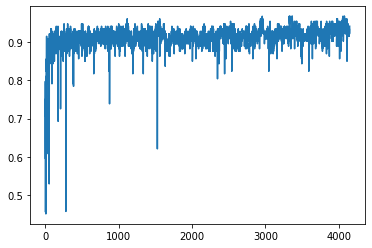

Epoch:  4151
Accuracy : 0.9411764705882353
Average prediction time 0.2035356721570415 31
Epoch:  4152
Accuracy : 0.9411764705882353
Average prediction time 0.20371497061944777 31
Epoch:  4153
Accuracy : 0.9150326797385621
Average prediction time 0.20352156700626498 31
Epoch:  4154
Accuracy : 0.9281045751633987
Average prediction time 0.20358435569270963 31
Epoch:  4155
Accuracy : 0.9150326797385621
Average prediction time 0.20349882495018742 31
Epoch:  4156
Accuracy : 0.9150326797385621
Average prediction time 0.20340326524549915 31
Epoch:  4157
Accuracy : 0.9150326797385621
Average prediction time 0.20357276547339656 31
Epoch:  4158
Accuracy : 0.9019607843137255
Average prediction time 0.20342373078869236 31
Epoch:  4159
Accuracy : 0.8954248366013072
Average prediction time 0.2035749573861399 31
Epoch:  4160
Accuracy : 0.8954248366013072
Average prediction time 0.20360178332174977 31
Epoch:  4161
Accuracy : 0.9019607843137255
Average prediction time 0.20333780780915292 31
Epoch:  4162

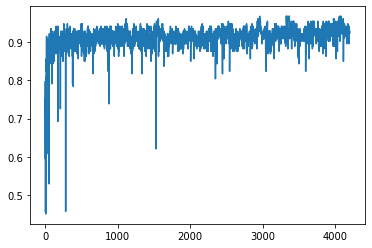

Epoch:  4201
Accuracy : 0.9281045751633987
Average prediction time 0.2034978251303396 31
Epoch:  4202
Accuracy : 0.934640522875817
Average prediction time 0.20341001787493307 31
Epoch:  4203
Accuracy : 0.9281045751633987
Average prediction time 0.20381182239901635 31
Epoch:  4204
Accuracy : 0.9281045751633987
Average prediction time 0.203459378211729 31
Epoch:  4205
Accuracy : 0.9215686274509803
Average prediction time 0.2033130814952235 31
Epoch:  4206
Accuracy : 0.9215686274509803
Average prediction time 0.20376129304209062 31
Epoch:  4207
Accuracy : 0.9281045751633987
Average prediction time 0.20341082542173325 31
Epoch:  4208
Accuracy : 0.934640522875817
Average prediction time 0.20400320329973776 31
Epoch:  4209
Accuracy : 0.9281045751633987
Average prediction time 0.20399122853432933 31
Epoch:  4210
Accuracy : 0.9281045751633987
Average prediction time 0.20334538336723082 31
Epoch:  4211
Accuracy : 0.9281045751633987
Average prediction time 0.20329023176623928 31
Epoch:  4212
Acc

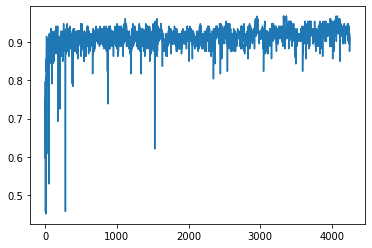

Epoch:  4251
Accuracy : 0.9215686274509803
Average prediction time 0.20374487292382024 31
Epoch:  4252
Accuracy : 0.9150326797385621
Average prediction time 0.20339283635539393 31
Epoch:  4253
Accuracy : 0.9150326797385621
Average prediction time 0.20380493902391003 31
Epoch:  4254
Accuracy : 0.9019607843137255
Average prediction time 0.20336088057487242 31
Epoch:  4255
Accuracy : 0.9019607843137255
Average prediction time 0.2035454011732532 31
Epoch:  4256
Accuracy : 0.9084967320261438
Average prediction time 0.20391546526262838 31
Epoch:  4257
Accuracy : 0.9411764705882353
Average prediction time 0.20346917644623788 31
Epoch:  4258
Accuracy : 0.934640522875817
Average prediction time 0.20339177500817082 31
Epoch:  4259
Accuracy : 0.9411764705882353
Average prediction time 0.20355160005630984 31
Epoch:  4260
Accuracy : 0.9084967320261438
Average prediction time 0.20346042417710827 31
Epoch:  4261
Accuracy : 0.934640522875817
Average prediction time 0.20344527306095248 31
Epoch:  4262


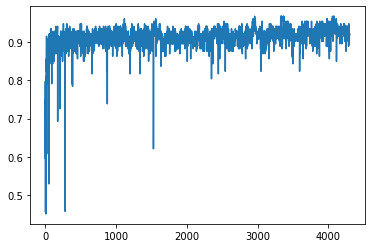

Epoch:  4301
Accuracy : 0.934640522875817
Average prediction time 0.2033214492182578 31
Epoch:  4302
Accuracy : 0.9411764705882353
Average prediction time 0.20356079839891003 31
Epoch:  4303
Accuracy : 0.9150326797385621
Average prediction time 0.20373092928240377 31
Epoch:  4304
Accuracy : 0.954248366013072
Average prediction time 0.20333347012919764 31
Epoch:  4305
Accuracy : 0.9411764705882353
Average prediction time 0.20350217050121677 31
Epoch:  4306
Accuracy : 0.9477124183006536
Average prediction time 0.2035192443478492 31
Epoch:  4307
Accuracy : 0.9411764705882353
Average prediction time 0.20316312389989052 31
Epoch:  4308
Accuracy : 0.954248366013072
Average prediction time 0.20361478097977176 31
Epoch:  4309
Accuracy : 0.954248366013072
Average prediction time 0.2033861452533353 31
Epoch:  4310
Accuracy : 0.9477124183006536
Average prediction time 0.2036034830154911 31
Epoch:  4311
Accuracy : 0.9411764705882353
Average prediction time 0.2035359028846987 31
Epoch:  4312
Accura

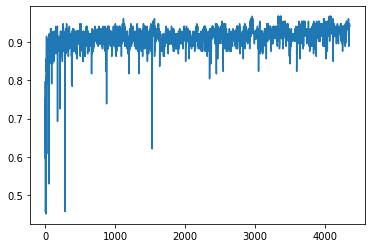

Epoch:  4351
Accuracy : 0.934640522875817
Average prediction time 0.2037696607651249 31
Epoch:  4352
Accuracy : 0.9411764705882353
Average prediction time 0.20344160449120305 31
Epoch:  4353
Accuracy : 0.9411764705882353
Average prediction time 0.20363227013618715 31
Epoch:  4354
Accuracy : 0.9411764705882353
Average prediction time 0.20344854170276272 31
Epoch:  4355
Accuracy : 0.934640522875817
Average prediction time 0.20352163622456212 31
Epoch:  4356
Accuracy : 0.934640522875817
Average prediction time 0.20350886160327541 31
Epoch:  4357
Accuracy : 0.934640522875817
Average prediction time 0.20326825880235241 31
Epoch:  4358
Accuracy : 0.934640522875817
Average prediction time 0.2034146708826865 31
Epoch:  4359
Accuracy : 0.934640522875817
Average prediction time 0.20343664384657337 31
Epoch:  4360
Accuracy : 0.9477124183006536
Average prediction time 0.20347850553451047 31
Epoch:  4361
Accuracy : 0.9477124183006536
Average prediction time 0.20347578294815555 31
Epoch:  4362
Accur

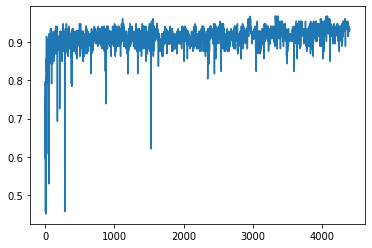

Epoch:  4401
Accuracy : 0.9150326797385621
Average prediction time 0.2033786312226326 31
Epoch:  4402
Accuracy : 0.9281045751633987
Average prediction time 0.2033092898707236 31
Epoch:  4403
Accuracy : 0.9281045751633987
Average prediction time 0.2032963845037645 31
Epoch:  4404
Accuracy : 0.9084967320261438
Average prediction time 0.20343152169258363 31
Epoch:  4405
Accuracy : 0.9215686274509803
Average prediction time 0.20349208001167543 31
Epoch:  4406
Accuracy : 0.9281045751633987
Average prediction time 0.20334019199494394 31
Epoch:  4407
Accuracy : 0.954248366013072
Average prediction time 0.20362905533083023 31
Epoch:  4408
Accuracy : 0.954248366013072
Average prediction time 0.20349847116777975 31
Epoch:  4409
Accuracy : 0.954248366013072
Average prediction time 0.20362382550393382 31
Epoch:  4410
Accuracy : 0.9411764705882353
Average prediction time 0.20346792282596712 31
Epoch:  4411
Accuracy : 0.9477124183006536
Average prediction time 0.20340194240693124 31
Epoch:  4412
Acc

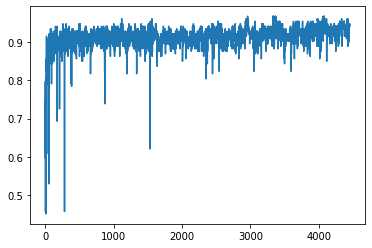

Epoch:  4451
Accuracy : 0.9477124183006536
Average prediction time 0.2033310397978752 31
Epoch:  4452
Accuracy : 0.9084967320261438
Average prediction time 0.20312573063758113 31
Epoch:  4453
Accuracy : 0.9411764705882353
Average prediction time 0.20339848918299522 31
Epoch:  4454
Accuracy : 0.9411764705882353
Average prediction time 0.20371780087870936 31
Epoch:  4455
Accuracy : 0.9411764705882353
Average prediction time 0.2035130762284802 31
Epoch:  4456
Accuracy : 0.9411764705882353
Average prediction time 0.2034969791289299 31
Epoch:  4457
Accuracy : 0.8954248366013072
Average prediction time 0.20349714063828991 31
Epoch:  4458
Accuracy : 0.9281045751633987
Average prediction time 0.20395669629496913 31
Epoch:  4459
Accuracy : 0.869281045751634
Average prediction time 0.20329058554864698 31
Epoch:  4460
Accuracy : 0.9084967320261438
Average prediction time 0.20336632574758223 31
Epoch:  4461
Accuracy : 0.9281045751633987
Average prediction time 0.20358297901768838 31
Epoch:  4462
A

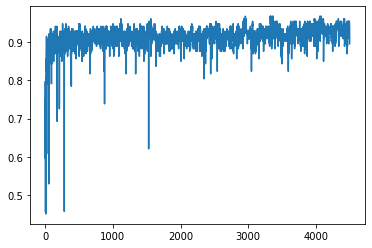

Epoch:  4501
Accuracy : 0.8888888888888888
Average prediction time 0.2033001684373425 31
Epoch:  4502
Accuracy : 0.9411764705882353
Average prediction time 0.20336687949395948 31
Epoch:  4503
Accuracy : 0.9150326797385621
Average prediction time 0.2035279889260569 31
Epoch:  4504
Accuracy : 0.934640522875817
Average prediction time 0.2035083693842734 31
Epoch:  4505
Accuracy : 0.954248366013072
Average prediction time 0.20357990264892578 31
Epoch:  4506
Accuracy : 0.9477124183006536
Average prediction time 0.2033705711364746 31
Epoch:  4507
Accuracy : 0.954248366013072
Average prediction time 0.20333163199886198 31
Epoch:  4508
Accuracy : 0.9477124183006536
Average prediction time 0.20355515326223067 31
Epoch:  4509
Accuracy : 0.9673202614379085
Average prediction time 0.20360869746054372 31
Epoch:  4510
Accuracy : 0.9673202614379085
Average prediction time 0.20373897398671797 31
Epoch:  4511
Accuracy : 0.9673202614379085
Average prediction time 0.20373196755686113 31
Epoch:  4512
Accu

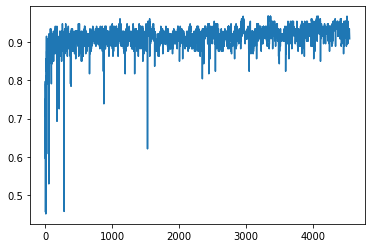

Epoch:  4551
Accuracy : 0.9281045751633987
Average prediction time 0.20336466450845042 31
Epoch:  4552
Accuracy : 0.9215686274509803
Average prediction time 0.20335968079105501 31
Epoch:  4553
Accuracy : 0.9215686274509803
Average prediction time 0.2032225670353059 31
Epoch:  4554
Accuracy : 0.934640522875817
Average prediction time 0.2036784541222357 31
Epoch:  4555
Accuracy : 0.934640522875817
Average prediction time 0.20329979927309097 31
Epoch:  4556
Accuracy : 0.9084967320261438
Average prediction time 0.20346202388886483 31
Epoch:  4557
Accuracy : 0.9150326797385621
Average prediction time 0.20337674694676552 31
Epoch:  4558
Accuracy : 0.9281045751633987
Average prediction time 0.20350570832529374 31
Epoch:  4559
Accuracy : 0.9281045751633987
Average prediction time 0.2036639028979886 31
Epoch:  4560
Accuracy : 0.9084967320261438
Average prediction time 0.20341778570605862 31
Epoch:  4561
Accuracy : 0.9215686274509803
Average prediction time 0.20343814357634513 31
Epoch:  4562
Ac

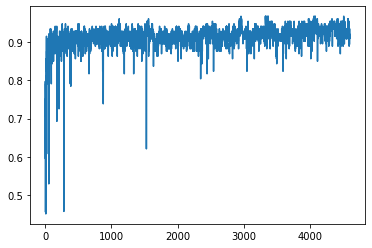

Epoch:  4601
Accuracy : 0.9084967320261438
Average prediction time 0.20366341836990848 31
Epoch:  4602
Accuracy : 0.9411764705882353
Average prediction time 0.20330374471602902 31
Epoch:  4603
Accuracy : 0.9411764705882353
Average prediction time 0.20331125874673167 31
Epoch:  4604
Accuracy : 0.934640522875817
Average prediction time 0.20343376744178035 31
Epoch:  4605
Accuracy : 0.934640522875817
Average prediction time 0.20329696901382938 31
Epoch:  4606
Accuracy : 0.934640522875817
Average prediction time 0.20312208514059743 31
Epoch:  4607
Accuracy : 0.9411764705882353
Average prediction time 0.20384751596758444 31
Epoch:  4608
Accuracy : 0.9411764705882353
Average prediction time 0.20354339384263562 31
Epoch:  4609
Accuracy : 0.934640522875817
Average prediction time 0.2034946257068265 31
Epoch:  4610
Accuracy : 0.9411764705882353
Average prediction time 0.20336127281188965 31
Epoch:  4611
Accuracy : 0.9281045751633987
Average prediction time 0.20355918330530967 31
Epoch:  4612
Ac

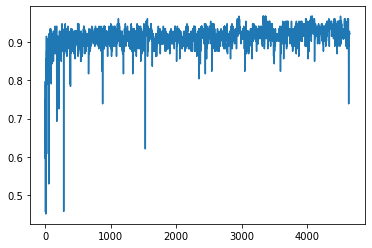

Epoch:  4651
Accuracy : 0.9281045751633987
Average prediction time 0.20360538267320202 31
Epoch:  4652
Accuracy : 0.934640522875817
Average prediction time 0.2035843941473192 31
Epoch:  4653
Accuracy : 0.934640522875817
Average prediction time 0.20341500928325038 31
Epoch:  4654
Accuracy : 0.934640522875817
Average prediction time 0.20369751222672 31
Epoch:  4655
Accuracy : 0.9281045751633987
Average prediction time 0.20343434426092333 31
Epoch:  4656
Accuracy : 0.9150326797385621
Average prediction time 0.2034385896498157 31
Epoch:  4657
Accuracy : 0.9150326797385621
Average prediction time 0.20346553094925418 31
Epoch:  4658
Accuracy : 0.9215686274509803
Average prediction time 0.20329766888772288 31
Epoch:  4659
Accuracy : 0.8954248366013072
Average prediction time 0.20340425737442508 31
Epoch:  4660
Accuracy : 0.9084967320261438
Average prediction time 0.20355249989417293 31
Epoch:  4661
Accuracy : 0.9281045751633987
Average prediction time 0.2034353825353807 31
Epoch:  4662
Accura

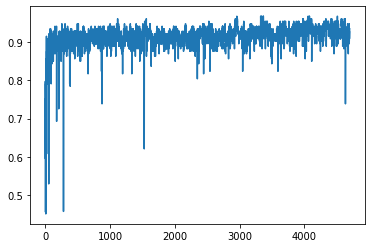

Epoch:  4701
Accuracy : 0.9281045751633987
Average prediction time 0.20338786801984232 31
Epoch:  4702
Accuracy : 0.9281045751633987
Average prediction time 0.2035463087020382 31
Epoch:  4703
Accuracy : 0.9084967320261438
Average prediction time 0.20348395839814218 31
Epoch:  4704
Accuracy : 0.9150326797385621
Average prediction time 0.203608182168776 31
Epoch:  4705
Accuracy : 0.9019607843137255
Average prediction time 0.2034963023278021 31
Epoch:  4706
Accuracy : 0.9150326797385621
Average prediction time 0.20326379037672473 31
Epoch:  4707
Accuracy : 0.934640522875817
Average prediction time 0.20345001835976878 31
Epoch:  4708
Accuracy : 0.9281045751633987
Average prediction time 0.2034711991586993 31
Epoch:  4709
Accuracy : 0.9150326797385621
Average prediction time 0.203903075187437 31
Epoch:  4710
Accuracy : 0.9215686274509803
Average prediction time 0.20344551917045348 31
Epoch:  4711
Accuracy : 0.9477124183006536
Average prediction time 0.20327886458366148 31
Epoch:  4712
Accur

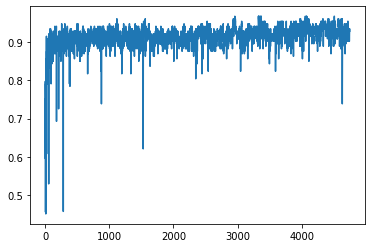

Epoch:  4751
Accuracy : 0.9281045751633987
Average prediction time 0.20358831651749149 31
Epoch:  4752
Accuracy : 0.934640522875817
Average prediction time 0.2035128608826668 31
Epoch:  4753
Accuracy : 0.9411764705882353
Average prediction time 0.20347212976024998 31
Epoch:  4754
Accuracy : 0.9281045751633987
Average prediction time 0.20365651192203646 31
Epoch:  4755
Accuracy : 0.9411764705882353
Average prediction time 0.2034319754569761 31
Epoch:  4756
Accuracy : 0.9215686274509803
Average prediction time 0.2035349876649918 31
Epoch:  4757
Accuracy : 0.934640522875817
Average prediction time 0.2037126556519539 31
Epoch:  4758
Accuracy : 0.9411764705882353
Average prediction time 0.20357394987537014 31
Epoch:  4759
Accuracy : 0.9281045751633987
Average prediction time 0.2033904598605248 31
Epoch:  4760
Accuracy : 0.9281045751633987
Average prediction time 0.2036516051138601 31
Epoch:  4761
Accuracy : 0.934640522875817
Average prediction time 0.20333233187275548 31
Epoch:  4762
Accura

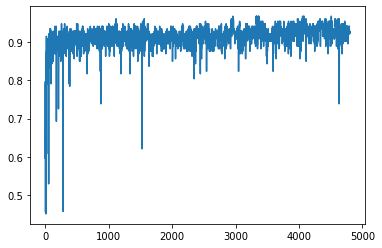

Epoch:  4801
Accuracy : 0.9150326797385621
Average prediction time 0.20345341005632955 31
Epoch:  4802
Accuracy : 0.9281045751633987
Average prediction time 0.20345544815063477 31
Epoch:  4803
Accuracy : 0.9215686274509803
Average prediction time 0.20368339938502159 31
Epoch:  4804
Accuracy : 0.9411764705882353
Average prediction time 0.20322075197773595 31
Epoch:  4805
Accuracy : 0.9477124183006536
Average prediction time 0.20363176253534132 31
Epoch:  4806
Accuracy : 0.9477124183006536
Average prediction time 0.20353680272256175 31
Epoch:  4807
Accuracy : 0.9477124183006536
Average prediction time 0.20341852403456165 31
Epoch:  4808
Accuracy : 0.9477124183006536
Average prediction time 0.20346369281891855 31
Epoch:  4809
Accuracy : 0.9477124183006536
Average prediction time 0.20339458988558862 31
Epoch:  4810
Accuracy : 0.9215686274509803
Average prediction time 0.2037007039593112 31
Epoch:  4811
Accuracy : 0.9150326797385621
Average prediction time 0.20330508293644076 31
Epoch:  481

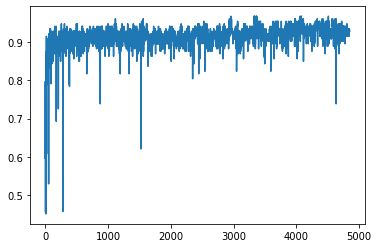

Epoch:  4851
Accuracy : 0.9281045751633987
Average prediction time 0.2035012552815099 31
Epoch:  4852
Accuracy : 0.9215686274509803
Average prediction time 0.20337158633816627 31
Epoch:  4853
Accuracy : 0.9411764705882353
Average prediction time 0.2035298808928459 31
Epoch:  4854
Accuracy : 0.9281045751633987
Average prediction time 0.20365826545223112 31
Epoch:  4855
Accuracy : 0.9215686274509803
Average prediction time 0.20375556330527028 31
Epoch:  4856
Accuracy : 0.9215686274509803
Average prediction time 0.203287624543713 31
Epoch:  4857
Accuracy : 0.9281045751633987
Average prediction time 0.20365884996229602 31
Epoch:  4858
Accuracy : 0.9411764705882353
Average prediction time 0.20362870154842252 31
Epoch:  4859
Accuracy : 0.934640522875817
Average prediction time 0.20321426083964686 31
Epoch:  4860
Accuracy : 0.934640522875817
Average prediction time 0.20356981215938444 31
Epoch:  4861
Accuracy : 0.934640522875817
Average prediction time 0.2034614009241904 31
Epoch:  4862
Accur

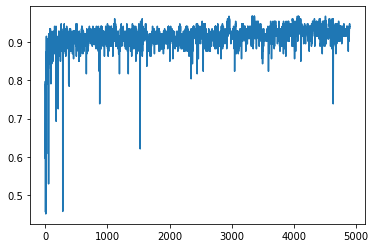

Epoch:  4901
Accuracy : 0.9411764705882353
Average prediction time 0.20348984964432254 31
Epoch:  4902
Accuracy : 0.9411764705882353
Average prediction time 0.2033494980104508 31
Epoch:  4903
Accuracy : 0.9411764705882353
Average prediction time 0.20386538197917323 31
Epoch:  4904
Accuracy : 0.9411764705882353
Average prediction time 0.20347409863625804 31
Epoch:  4905
Accuracy : 0.9411764705882353
Average prediction time 0.20325519192603328 31
Epoch:  4906
Accuracy : 0.9411764705882353
Average prediction time 0.20332130309074156 31
Epoch:  4907
Accuracy : 0.934640522875817
Average prediction time 0.2035886626089773 31
Epoch:  4908
Accuracy : 0.934640522875817
Average prediction time 0.20383711015024492 31
Epoch:  4909
Accuracy : 0.9411764705882353
Average prediction time 0.20339069827910392 31
Epoch:  4910
Accuracy : 0.9411764705882353
Average prediction time 0.2034037959191107 31
Epoch:  4911
Accuracy : 0.9411764705882353
Average prediction time 0.20350143986363564 31
Epoch:  4912
Ac

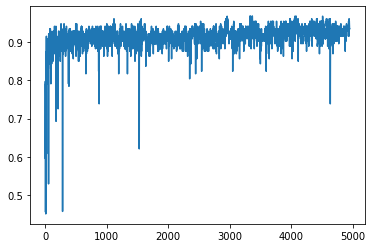

Epoch:  4951
Accuracy : 0.934640522875817
Average prediction time 0.2033821536648658 31
Epoch:  4952
Accuracy : 0.934640522875817
Average prediction time 0.2037786514528336 31
Epoch:  4953
Accuracy : 0.9281045751633987
Average prediction time 0.20327751098140592 31
Epoch:  4954
Accuracy : 0.9281045751633987
Average prediction time 0.2037330058313185 31
Epoch:  4955
Accuracy : 0.9215686274509803
Average prediction time 0.20351149189856746 31
Epoch:  4956
Accuracy : 0.934640522875817
Average prediction time 0.2032917699506206 31
Epoch:  4957
Accuracy : 0.9477124183006536
Average prediction time 0.20348957277113391 31
Epoch:  4958
Accuracy : 0.934640522875817
Average prediction time 0.2034986634408274 31
Epoch:  4959
Accuracy : 0.9411764705882353
Average prediction time 0.203447780301494 31
Epoch:  4960
Accuracy : 0.9411764705882353
Average prediction time 0.20332706359124952 31
Epoch:  4961
Accuracy : 0.9411764705882353
Average prediction time 0.2035044470141011 31
Epoch:  4962
Accuracy 

0.8954248366013072

In [15]:
# elif args.fine_tune:
# ---------------------- Fine Tune ------------------
base_model = torch.load("decomposed_model")
model = torch.nn.DataParallel(base_model)

for param in model.parameters():
    param.requires_grad = True

print(model)
model.cuda(device)

for name, param in model.named_parameters():
    print("\t",name, param.requires_grad)
    

# if args.cp:
if cp:
    optimizer = optim.SGD(model.parameters(), lr=0.000001)
else:
    # optimizer = optim.SGD(chain(model.features.parameters(), \
    #     model.classifier.parameters()), lr=0.01)
    optimizer = optim.SGD(model.parameters(), lr=0.001)


trainer = Trainer('data/hymenoptera_data/train', 'data/hymenoptera_data/val', model, optimizer)

print("first test: ==============")
trainer.test()


print("first train: ==============")
model.cuda(device)
model.train()
trainer.train(epoches=5000)
model.eval()

print("second test: ==============")
trainer.test()

In [69]:
torch.gesv(a,b)

AttributeError: module 'torch' has no attribute 'gesv'